# Import packages

In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import torch
from torch.optim import Adam
import scipy.stats as stat
from scipy.stats import multivariate_normal
import sbi
import lsbi
from lsbi.network import BinaryClassifierLPop, BinaryClassifier
import math
import sys
import pickle
from datetime import datetime
import IPython
from concurrent.futures import ThreadPoolExecutor, TimeoutError
import time
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interactive, HBox, VBox
import plotly.graph_objects as go
from ipywidgets import interact, FloatSlider
from torch import nn
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from scipy.stats import norm
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.ticker as ticker

# Set up

In [23]:
class optim_p3_poisson:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.5, -5.2, -0.95, -0.1], high=[1.9 * 10**5, 5, -11, -3.5, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        # print(f"Norm = {norm_ft}")
        # print(f"Base function = {((1 - x ** self.c_e_ft) ** b_ft)}")
        # print(f"X function = {x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)}")
        # print(f"BW2 = {BW2}")
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        # y = y.round()
        return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)

    def threshold(self):
        return 25

    def adjust_theta_3(self):
        priors = self.create_priors()
        theta_opt = []
        for i in range(len(priors)):
            theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
        theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
        y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
        
        if self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) > self.threshold():
            while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
                priors = self.create_priors()
                theta_opt = []
                for i in range(len(priors)):
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
                y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        else:
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
            theta_opt = theta_opt
            y_pred_3 = y_pred_3
        return loss, theta_opt, y_pred_3

    def run(self):
        
        success = False

        while not success:
            initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3()
            theta_initial = theta_opt.clone().detach()
            self.theta_initial = theta_initial

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1400
            loss_crit = 1.5
            loss_filter = 3.37
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                    # print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 1000 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    # print(f"Final loss before filter = {losses[-1]}")
                    break
                # if N_iter == 1000 and loss < loss_filter:
                #     print(f"Loss at 1000 iterations = {loss}")
                # if N_iter == 1000 and loss < loss_filter:
                #     print(f"Loss at 1000 iterations = {loss}")
                # if N_iter == 1500 and loss < loss_filter:
                #     print(f"Loss at 1500 iterations = {loss}")
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success == True:

            self.losses = np.array(losses)

            theta_final = []

            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])

            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
            self.max_N = max_N
            self.loss_filter = loss_filter
            self.N_iter_filter = N_iter_filter
            self.learning_rate = lr
            self.losses = np.array(losses)
        
            # print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            
            # # Save results if good

            # timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            # filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
            # filename_theta_final = f"Theta_3_final_{timestamp}.txt"

            # with open(filename_theta_initial, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))
            # with open(filename_theta_final, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = curve_torch_3(x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")




            # # Plot results

            # plt.errorbar(self.De_mass, self.De_event, yerr=self.yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(self.De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 5000)
            # plt.ylim(bottom = 10**-2, top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000, 5000])
            # plt.title("True data")
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")
            # # a_loss.set_xlim(N_iter-1000, N_iter)
            # # a_loss.set_ylim(0.55, 0.6)

# Define events as number of events total, this is the realy experimental data, not events per bin

def load_and_process_data(data_path):
    De = pd.read_csv(data_path, usecols=["Mass [GeV]", "Mass [GeV] LOW", "Mass [GeV] HIGH", "Events/10 GeV"])
    De_mass = De["Mass [GeV]"].values
    De_events_scaled = (De["Mass [GeV] HIGH"].values - De["Mass [GeV] LOW"].values) * De["Events/10 GeV"].values
    De_events_scaled_min = min([i for i in De_events_scaled if i != 0])
    De_event = De_events_scaled / De_events_scaled_min
    yerr = np.sqrt(De_event)
    return De_mass, De_event, yerr

data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'

De_mass, De_event, yerr = load_and_process_data(data_path)


# Model Comparison: SBI

## i2 vs i3 BCT i2 data

### Histogram varying training rounds

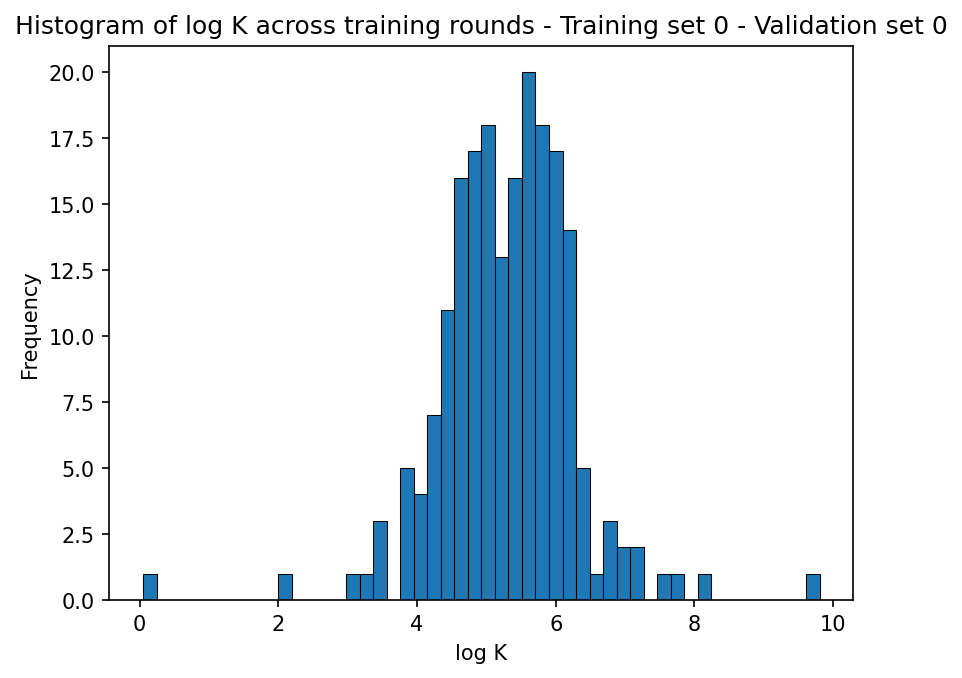

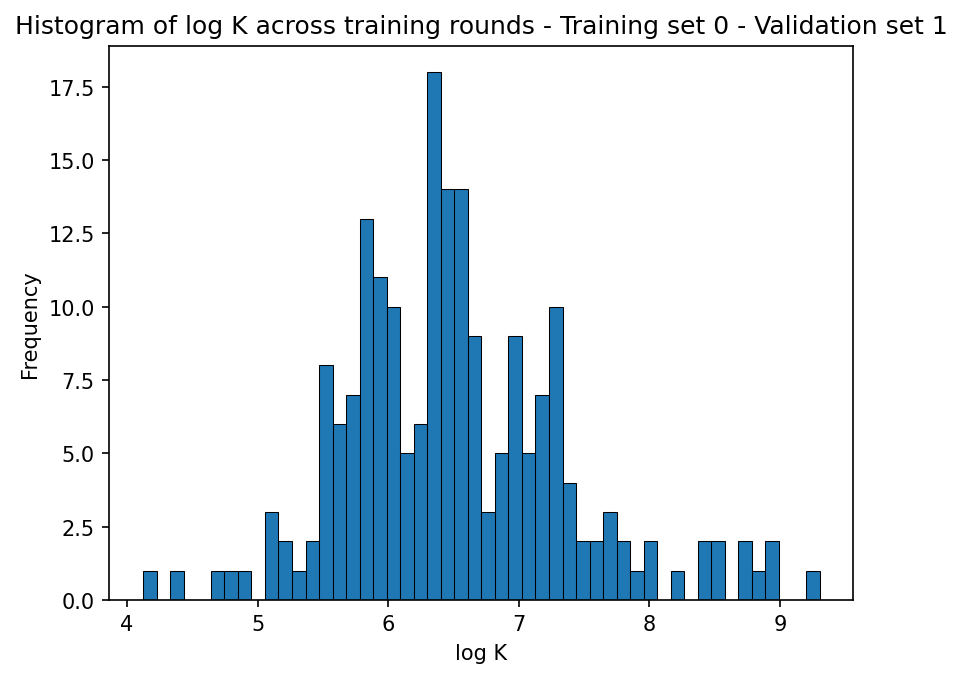

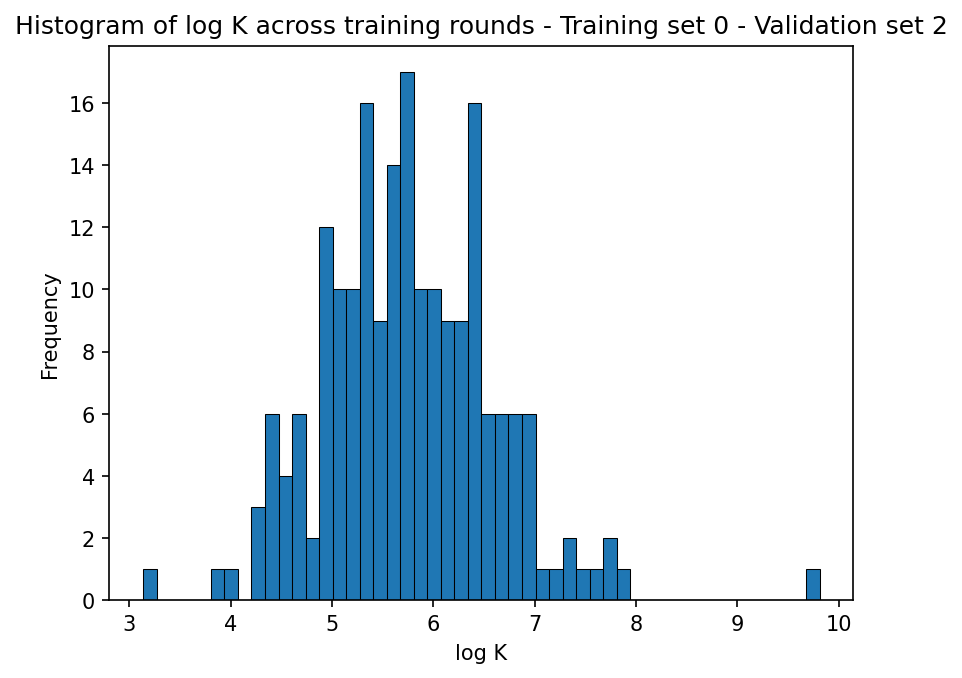

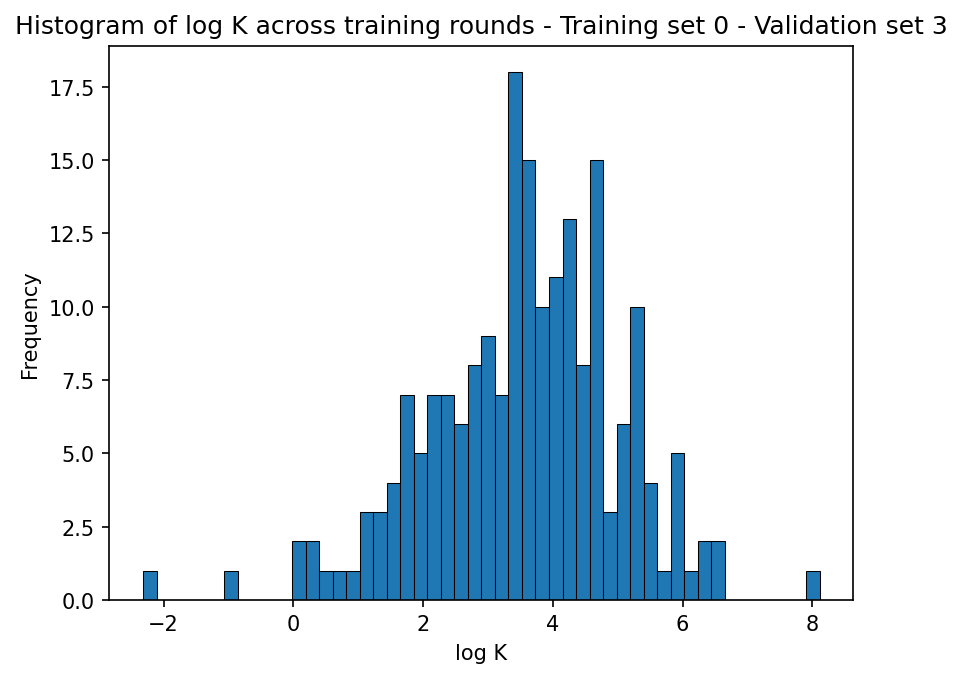

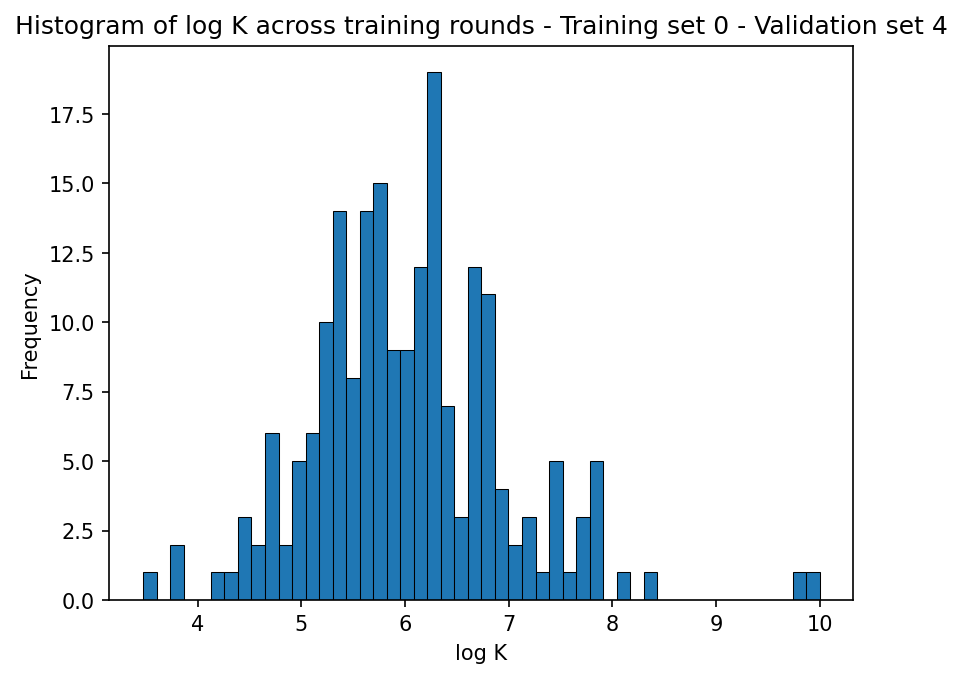

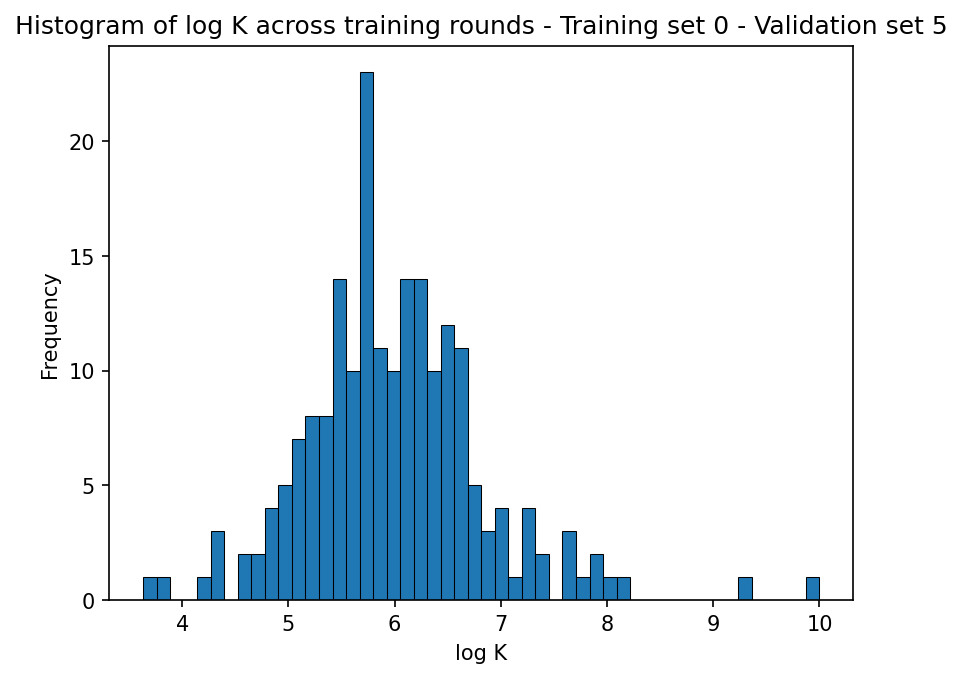

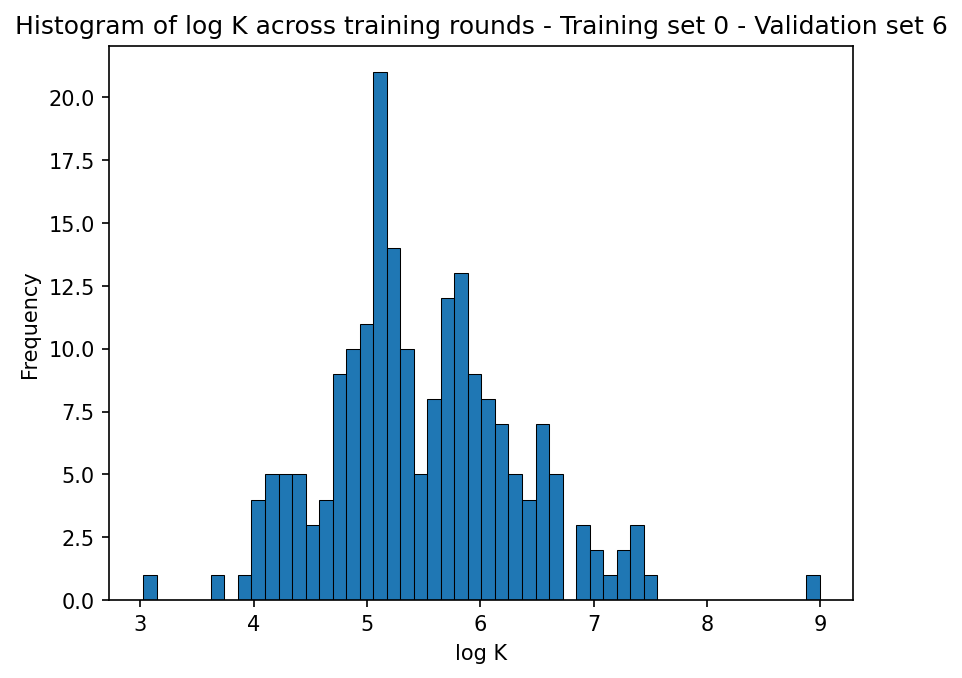

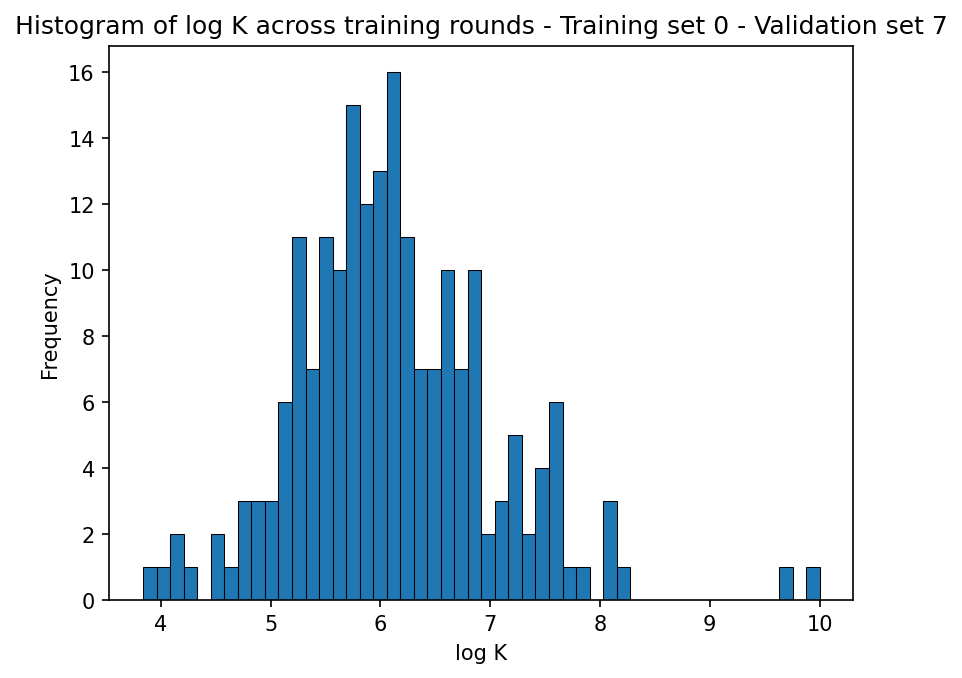

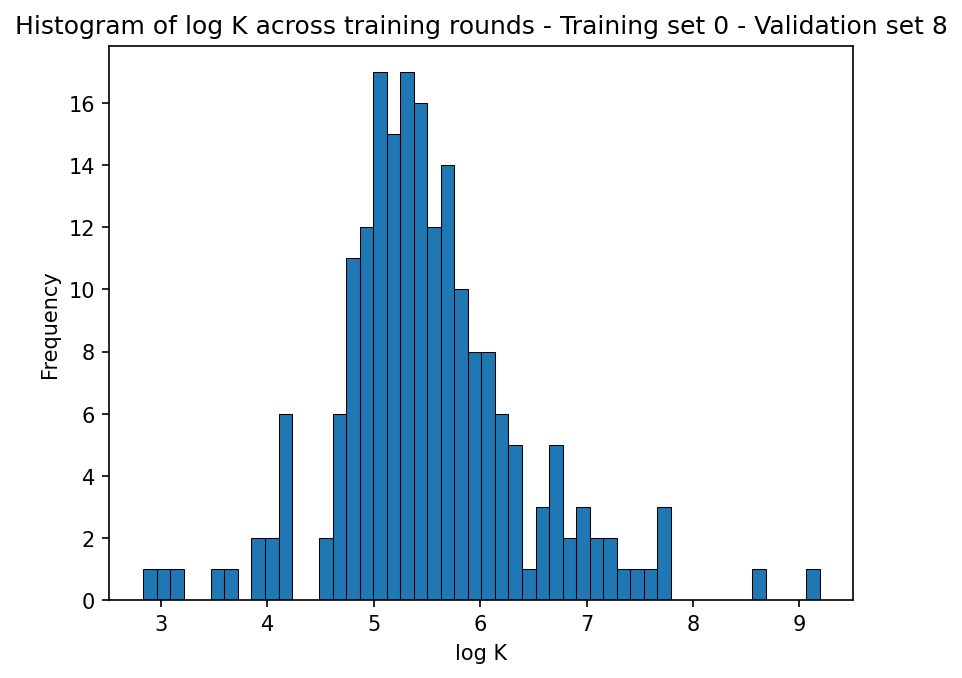

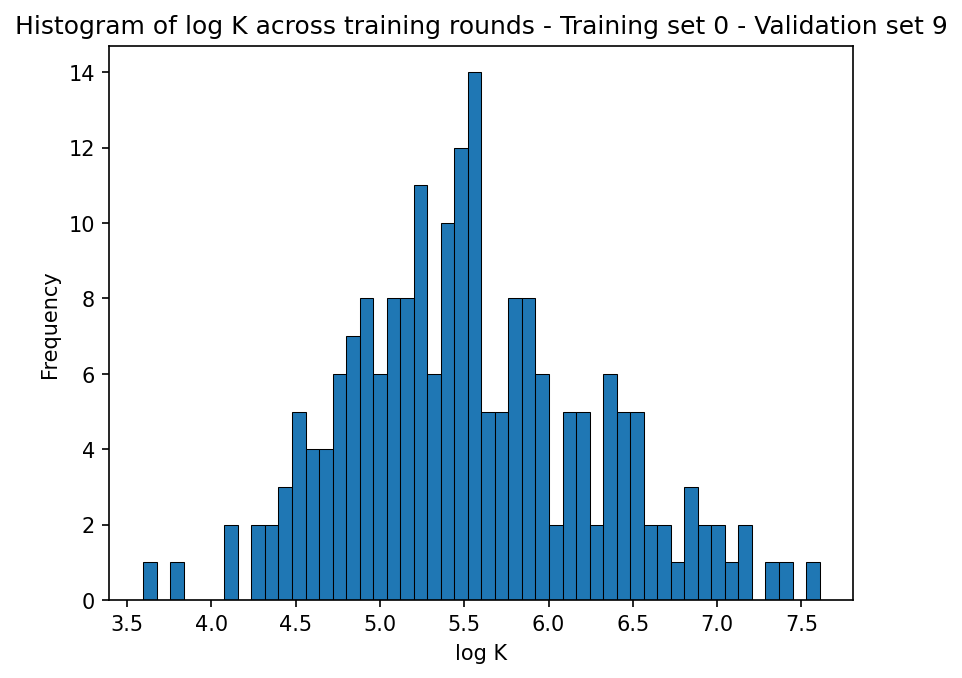

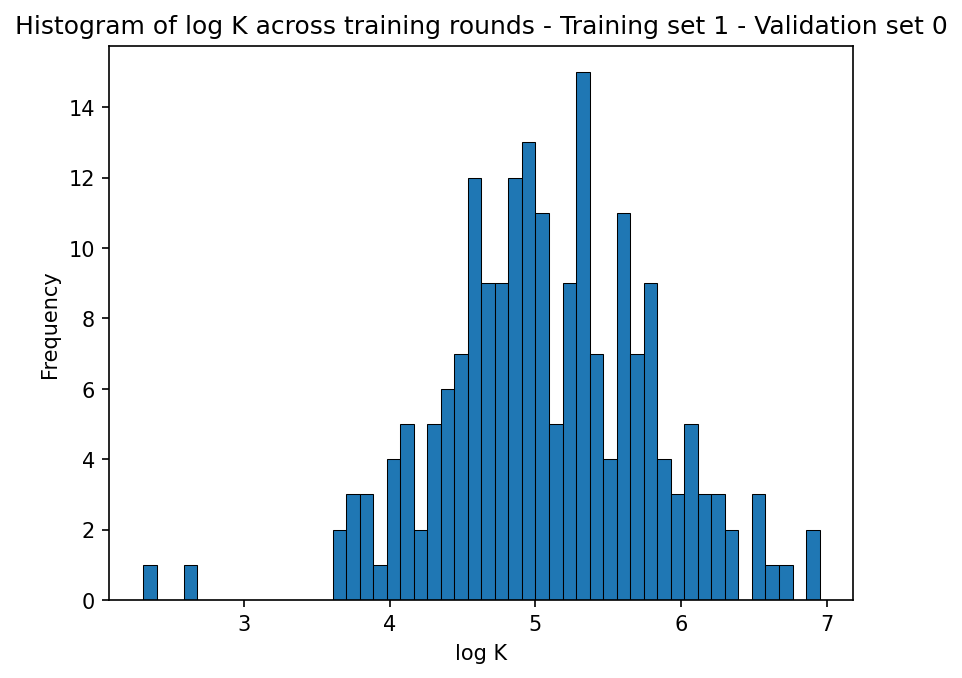

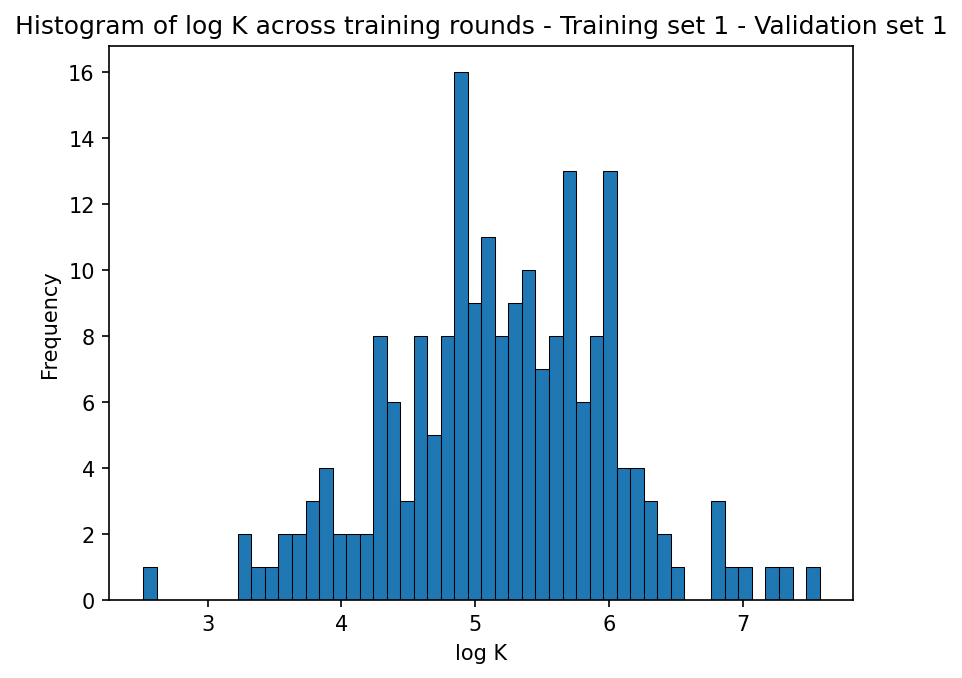

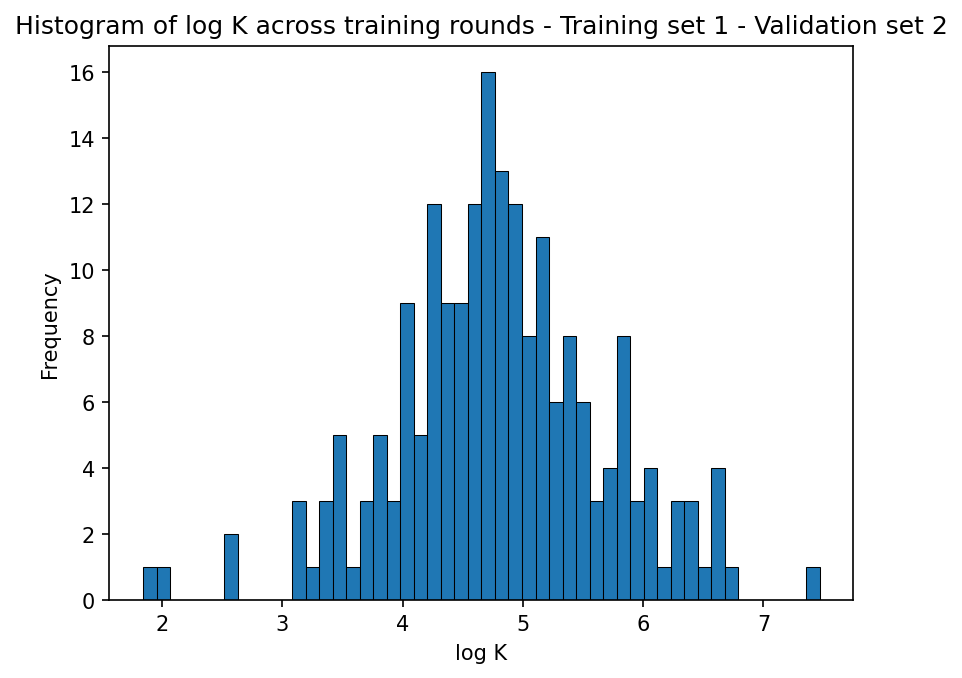

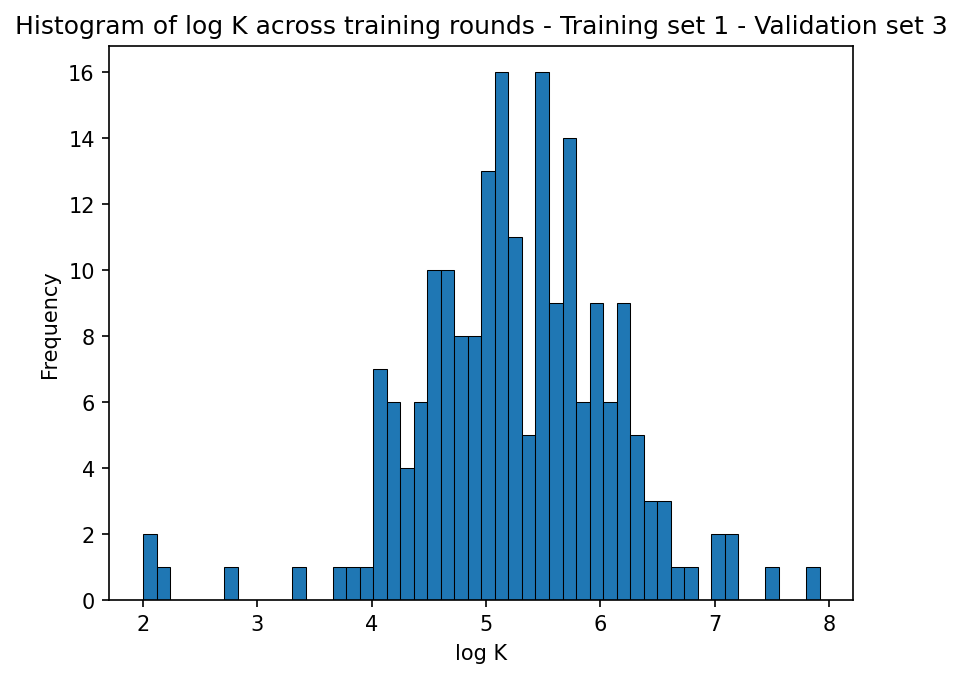

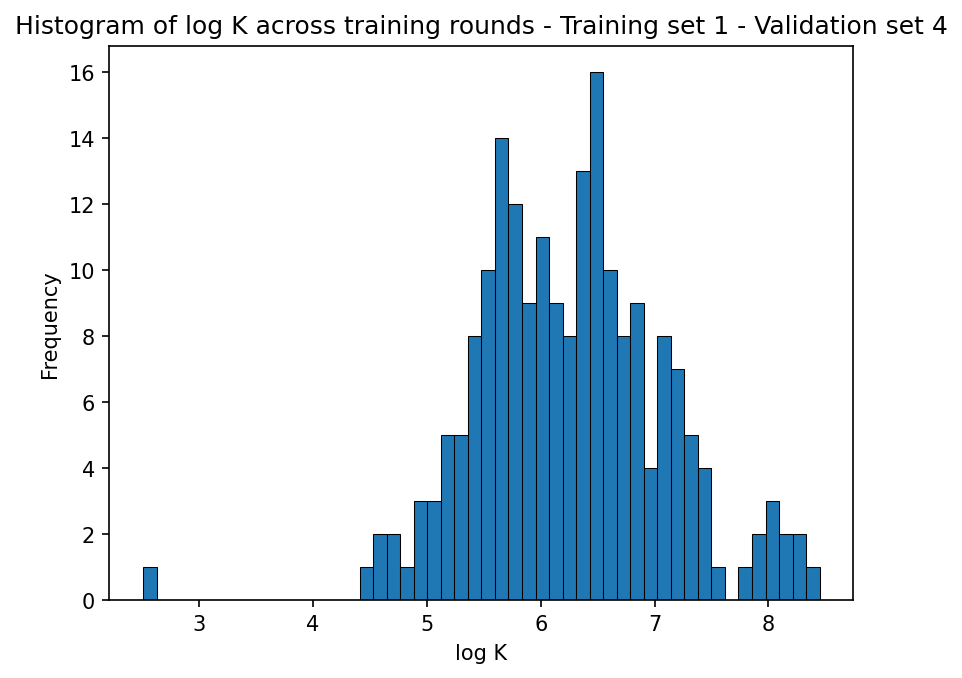

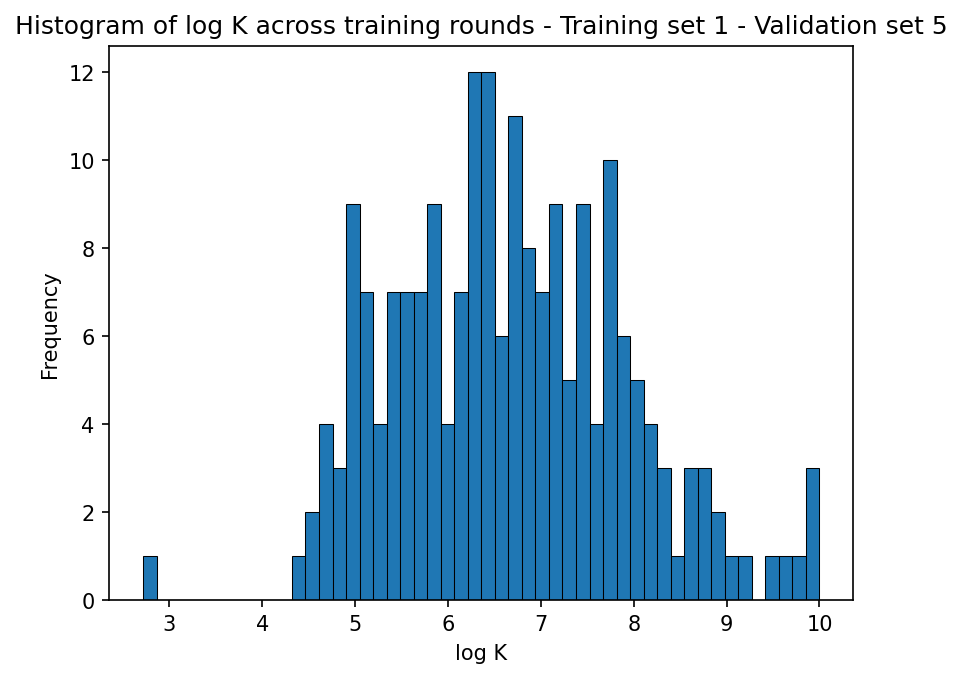

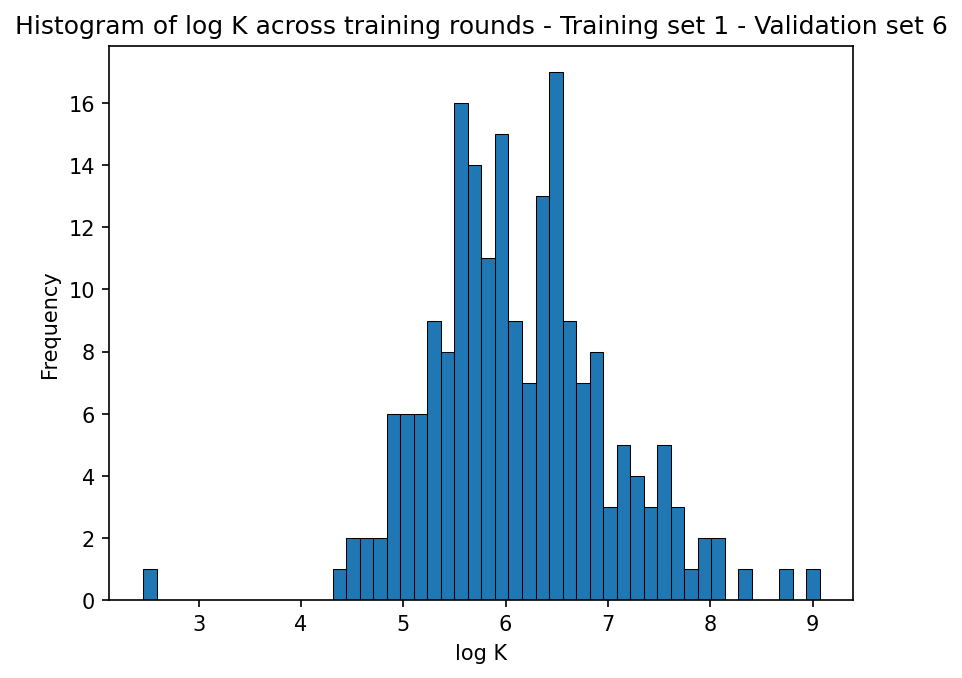

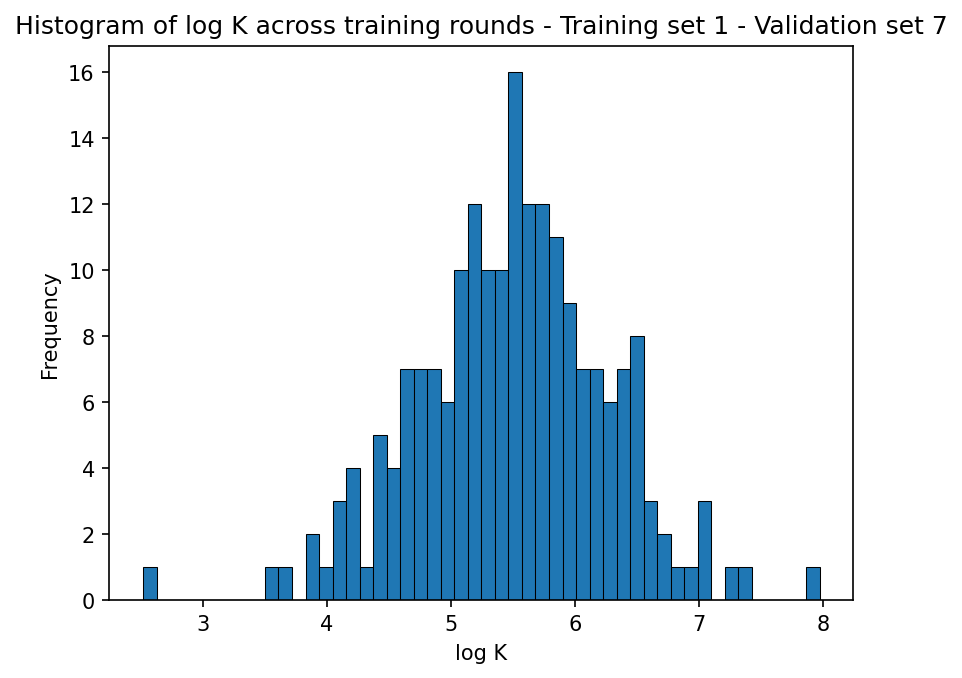

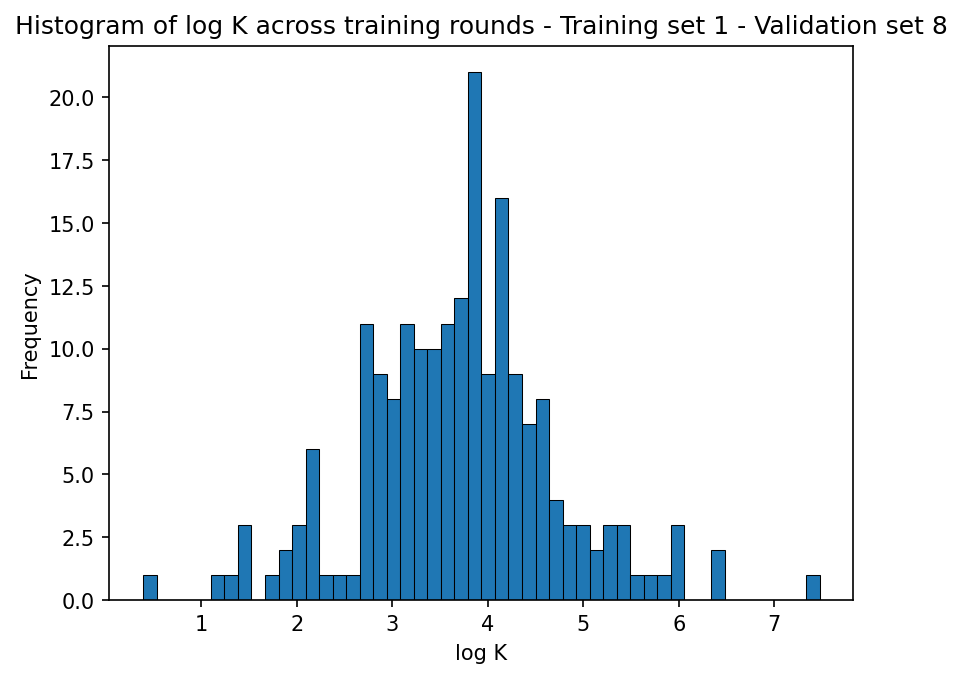

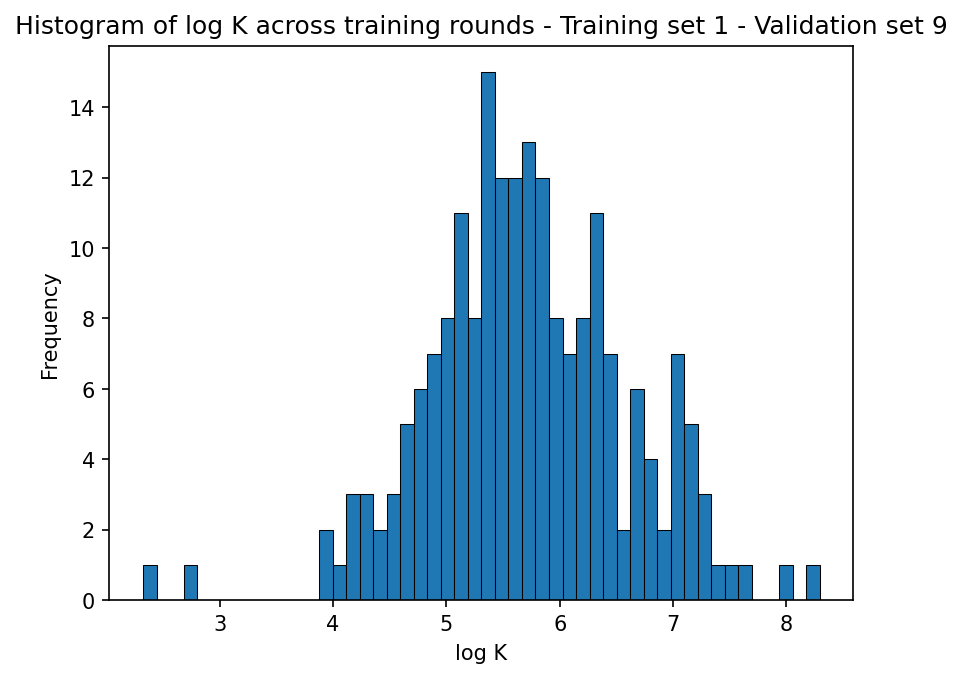

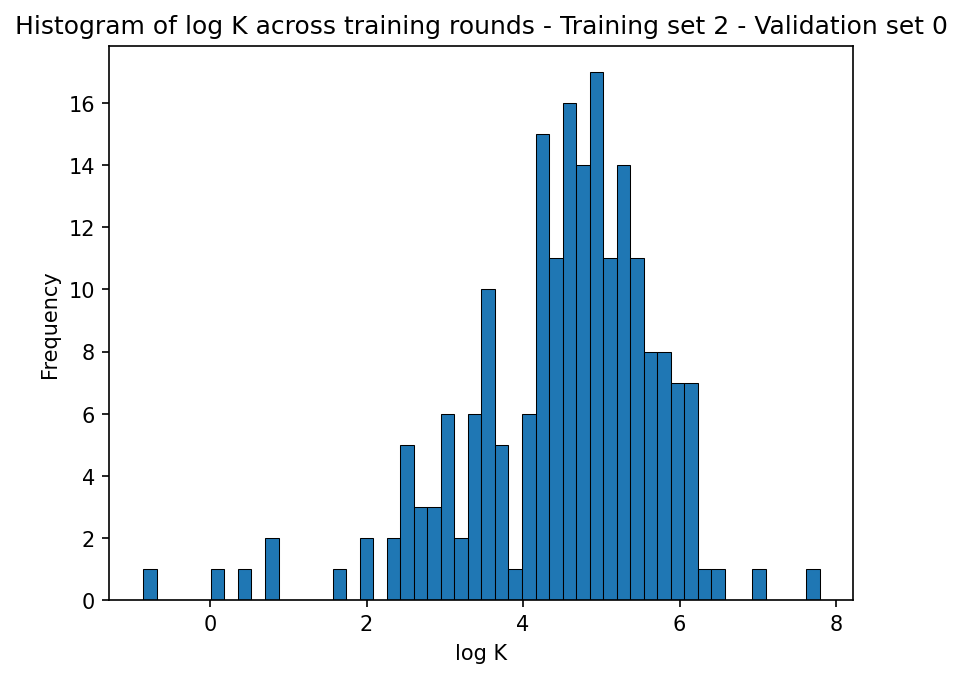

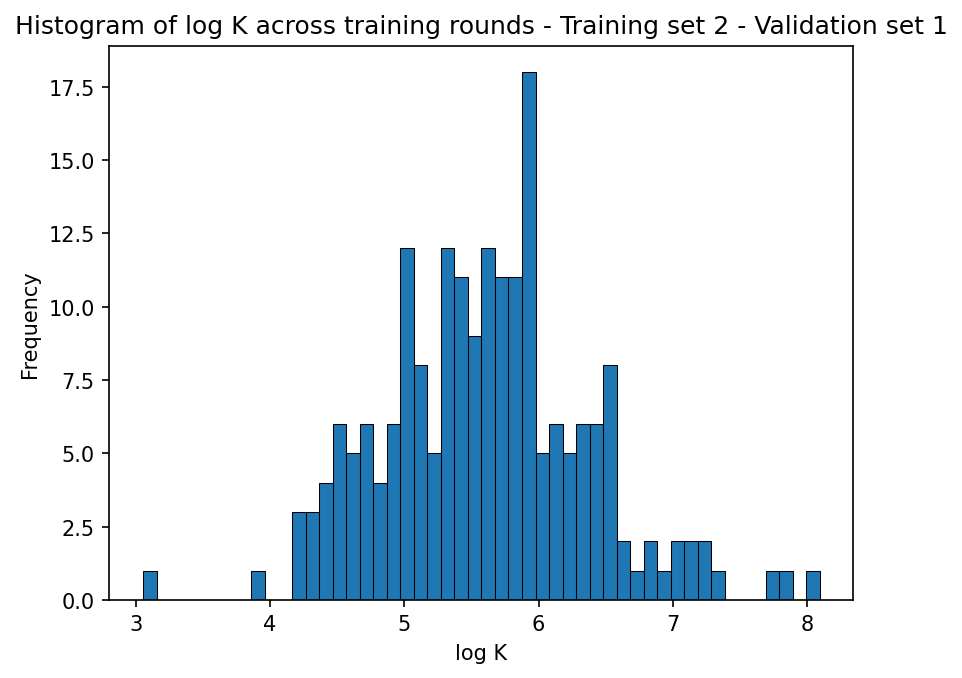

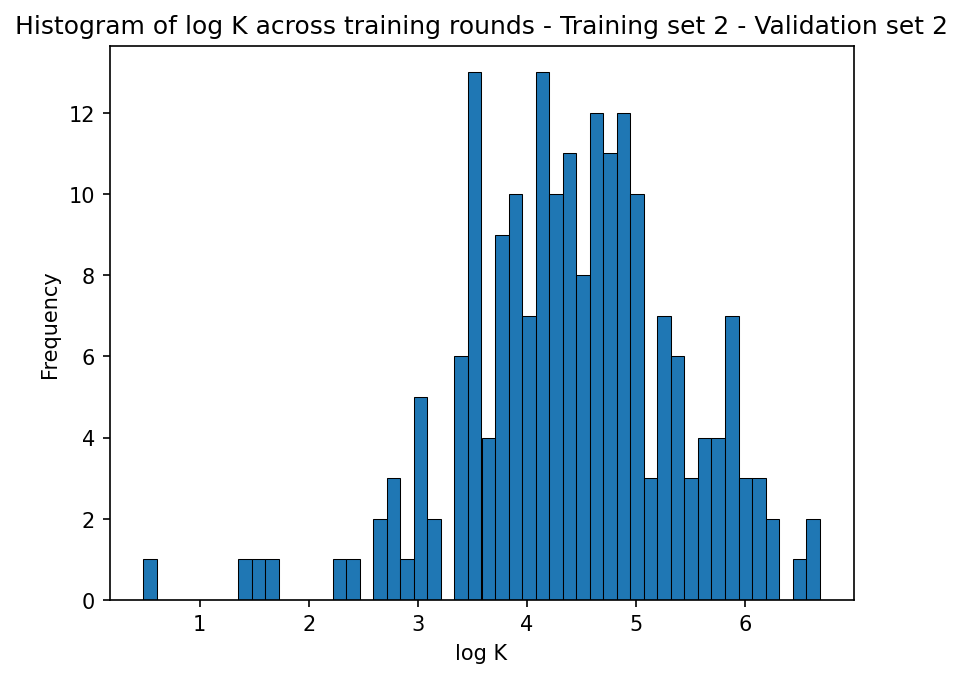

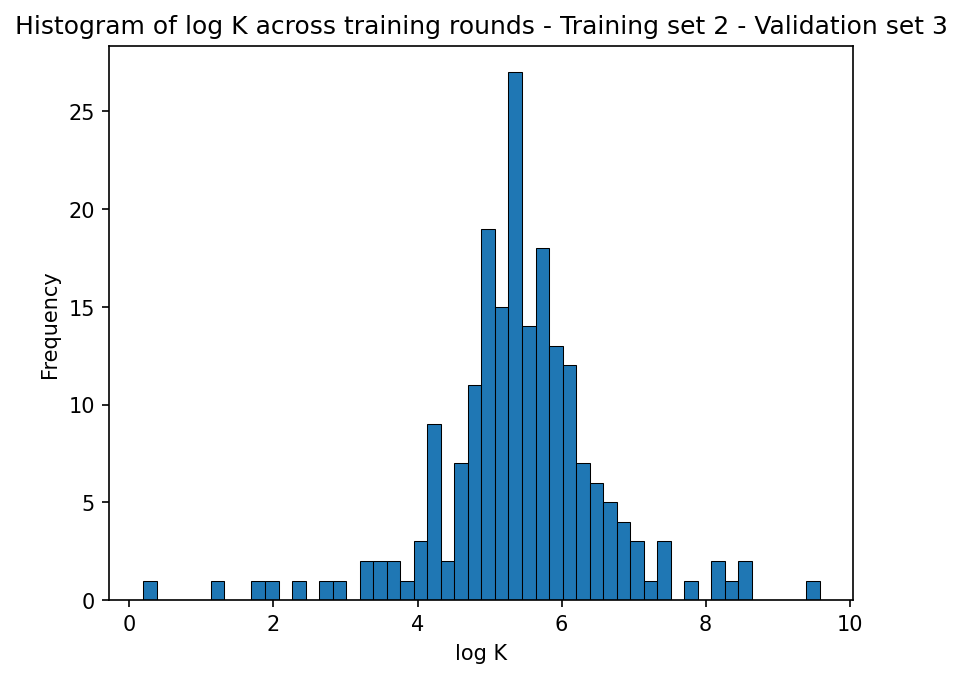

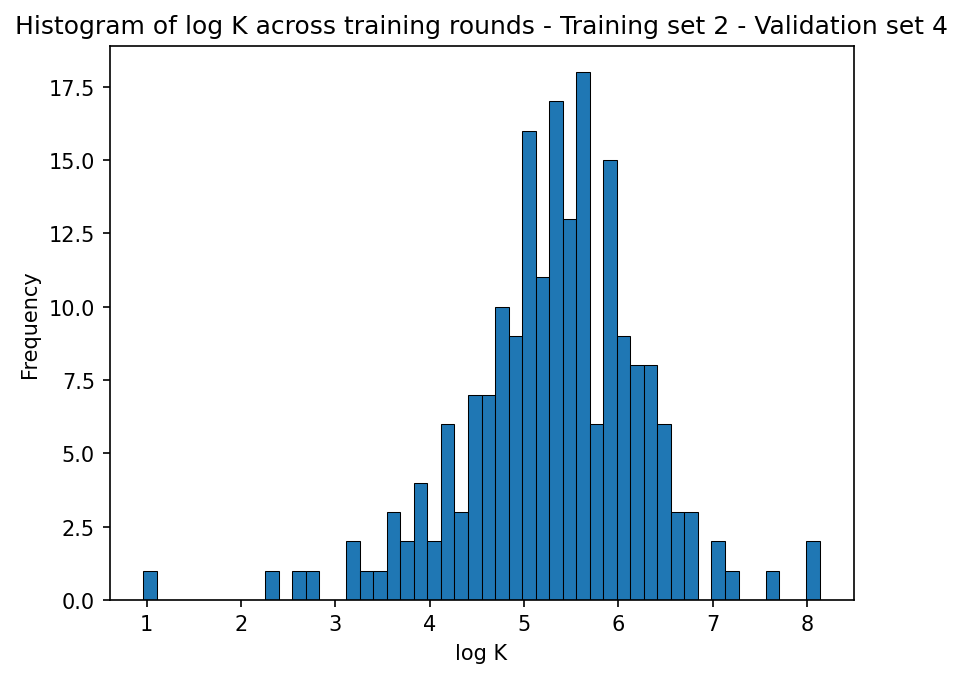

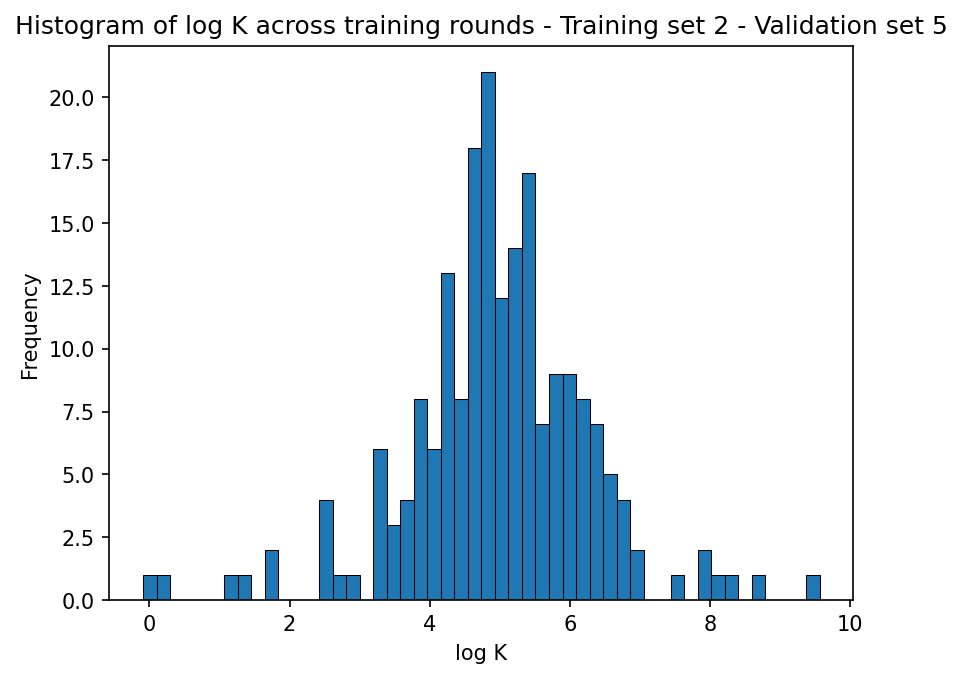

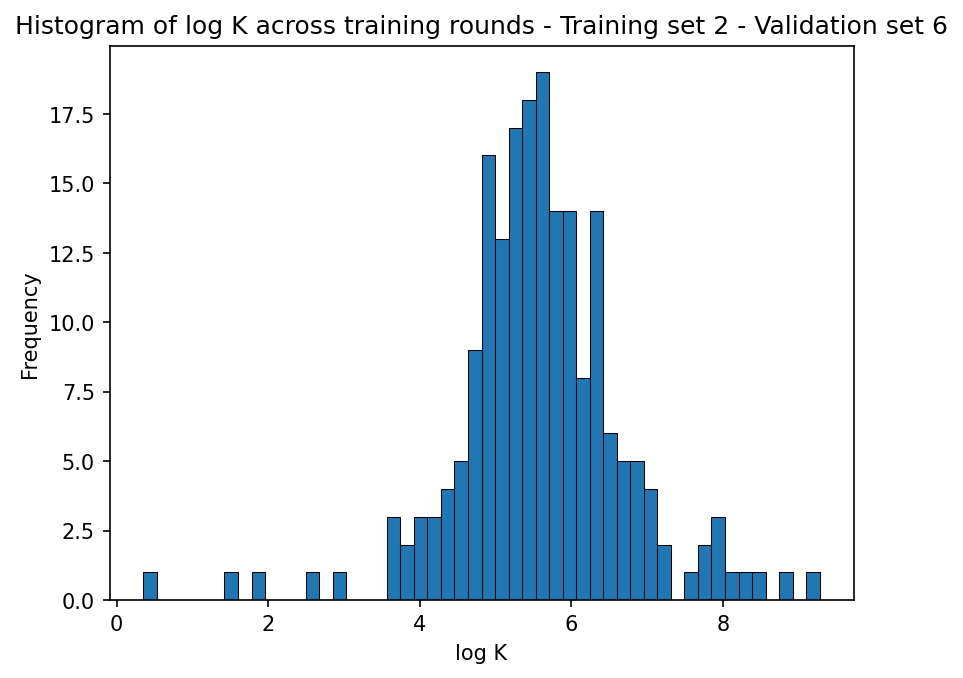

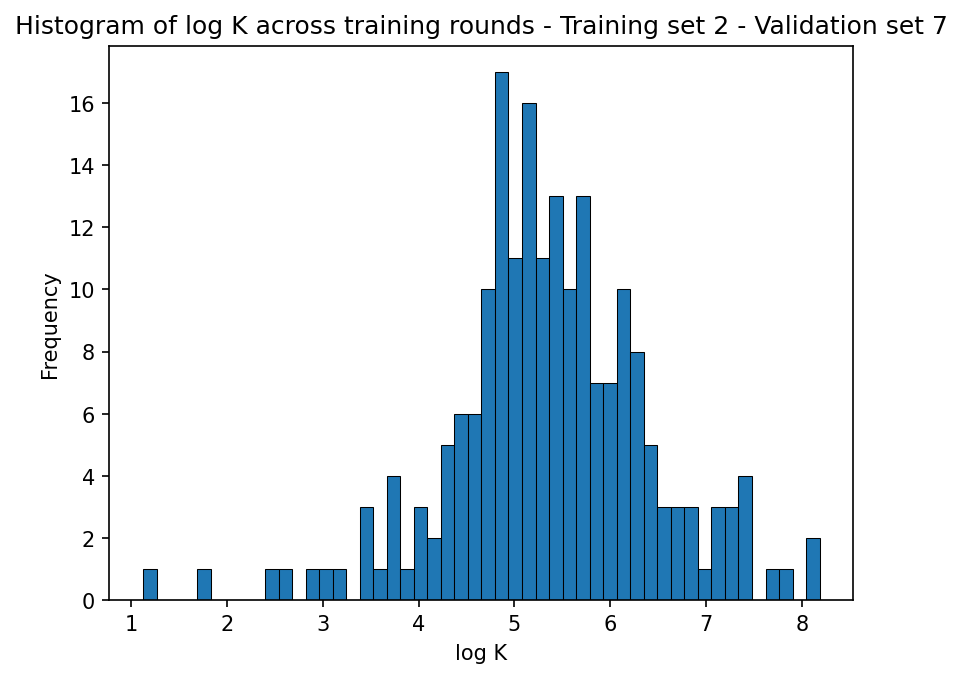

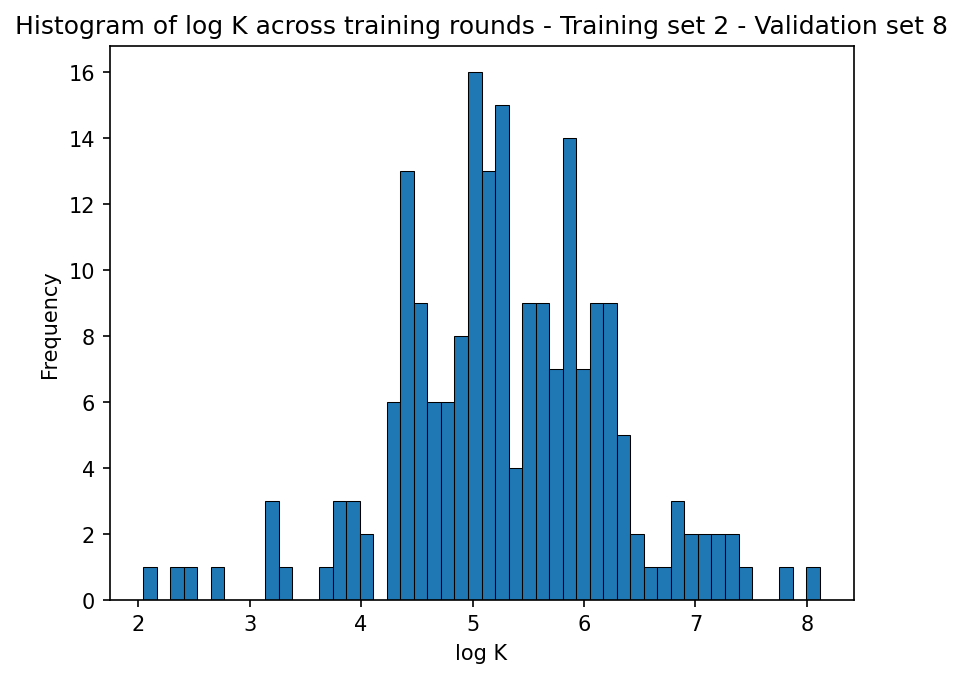

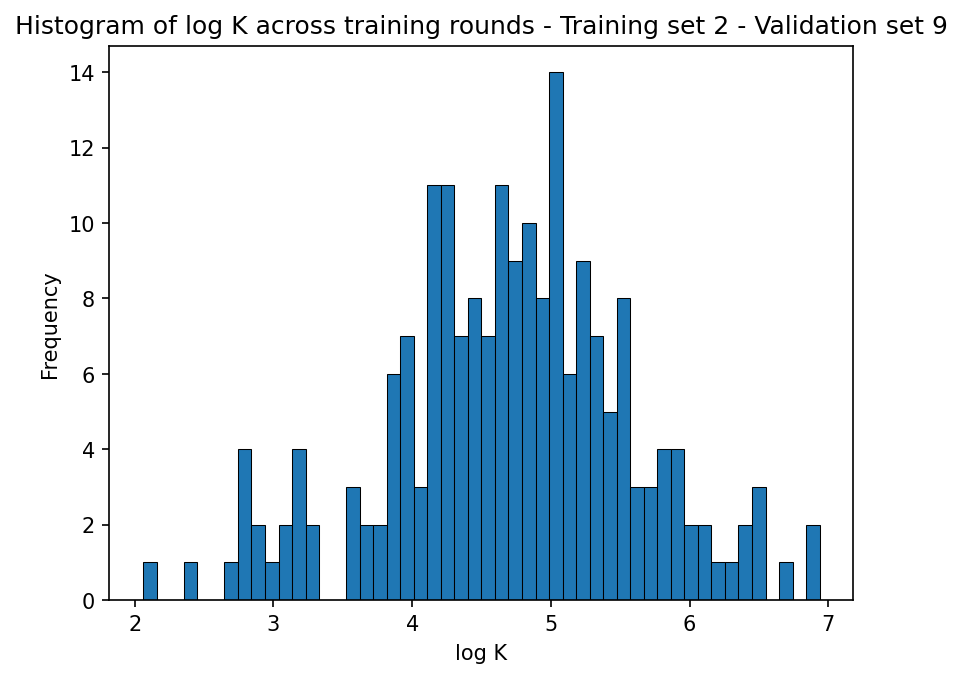

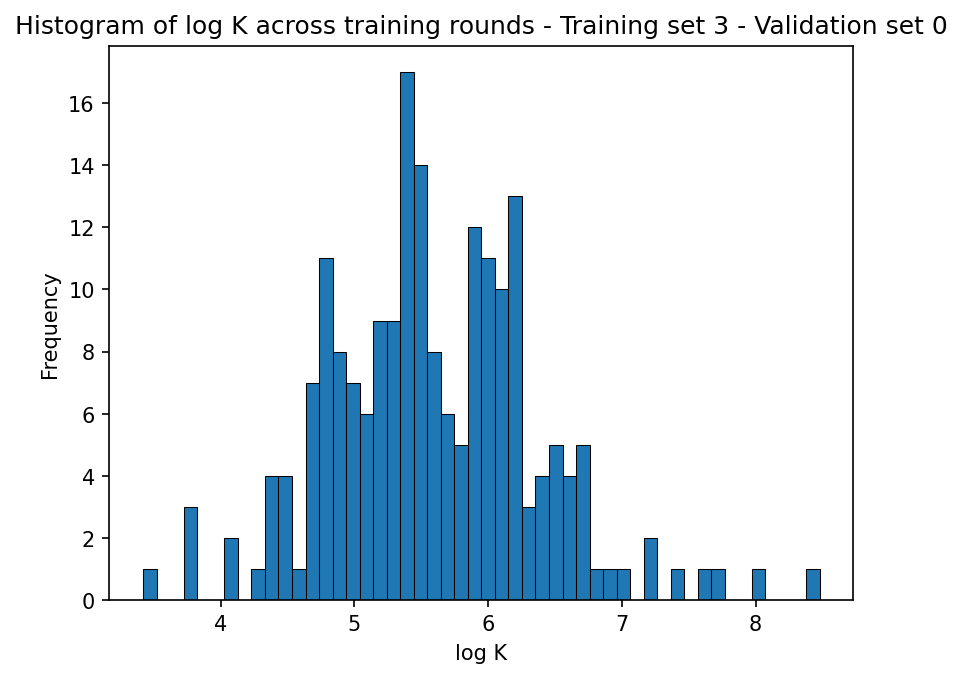

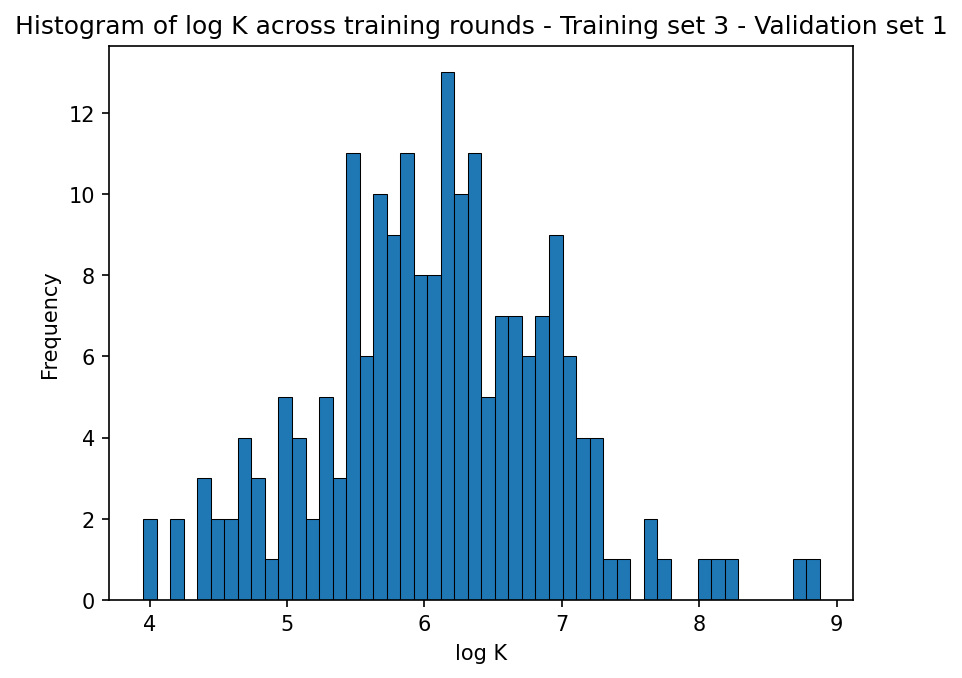

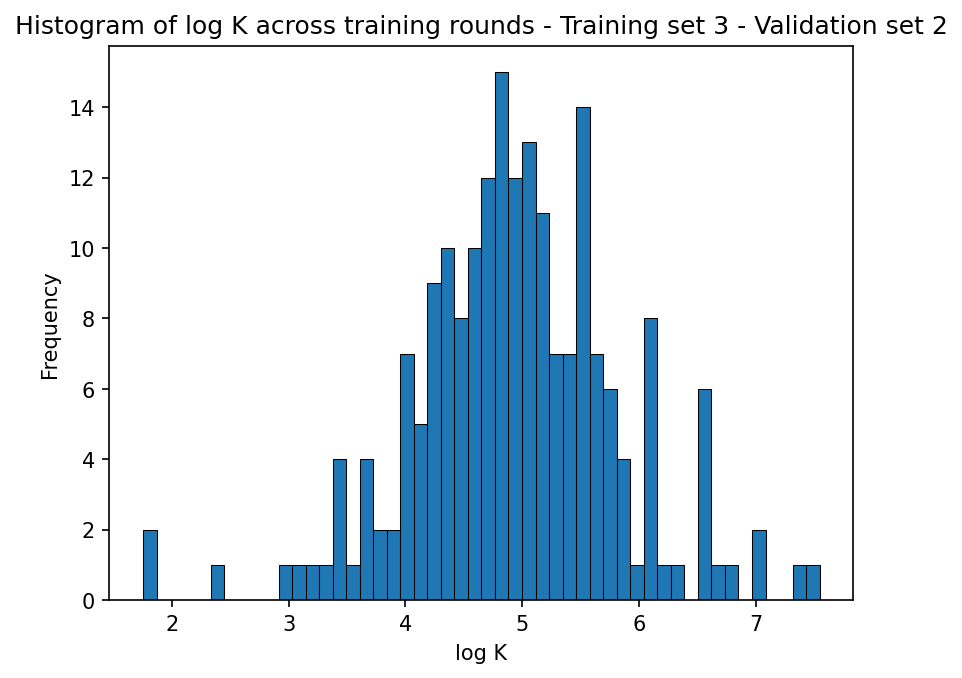

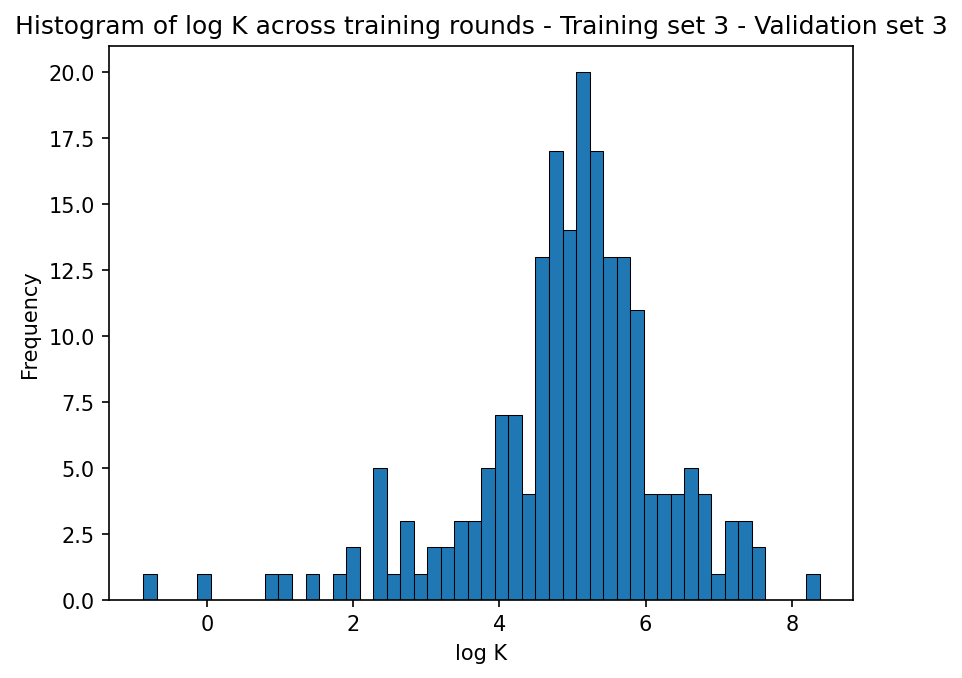

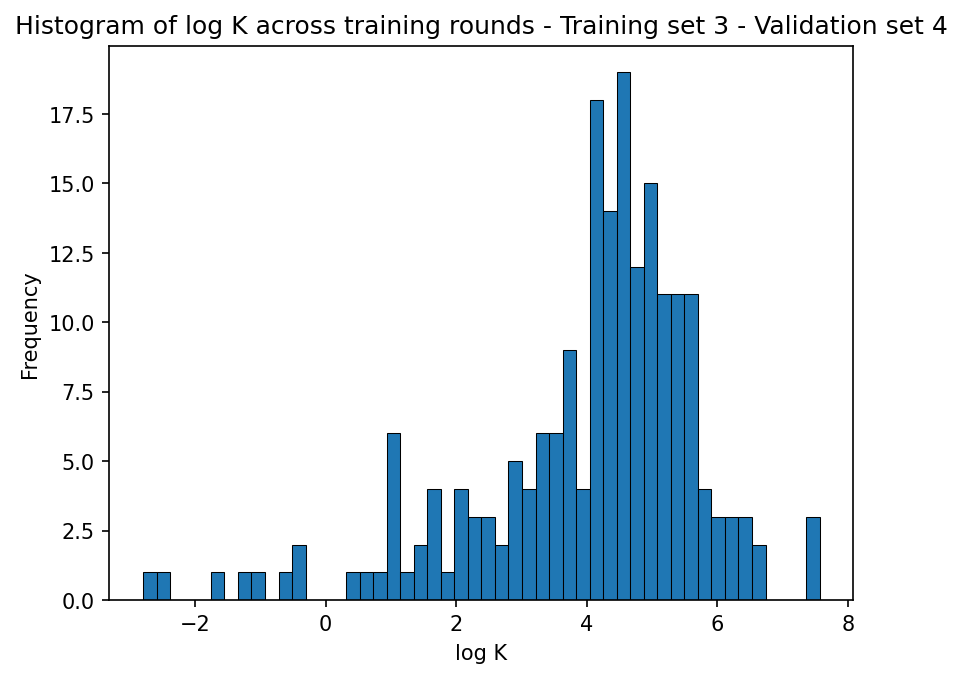

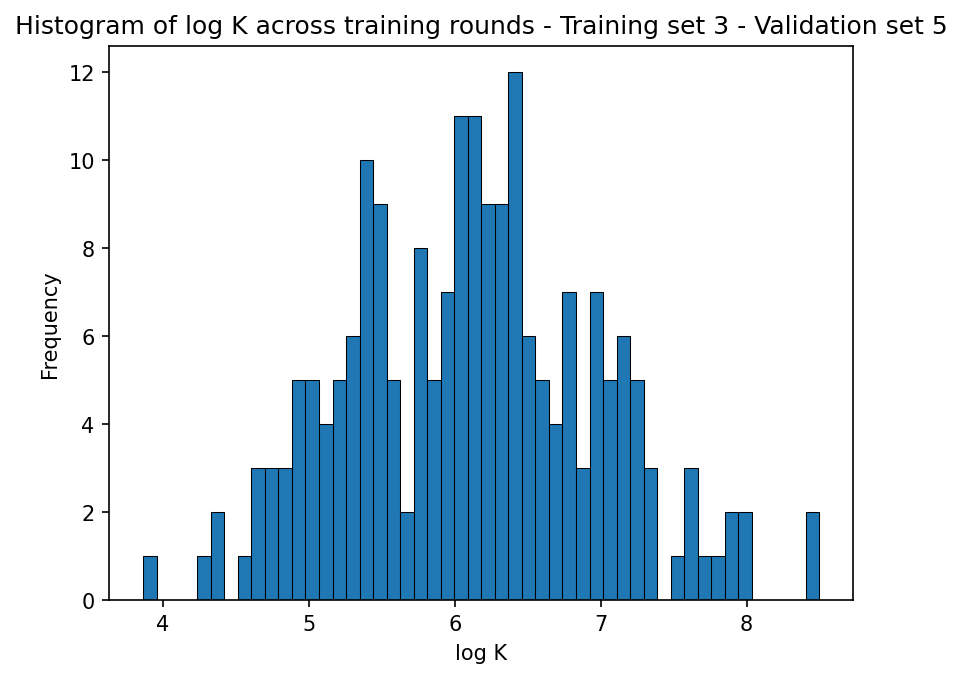

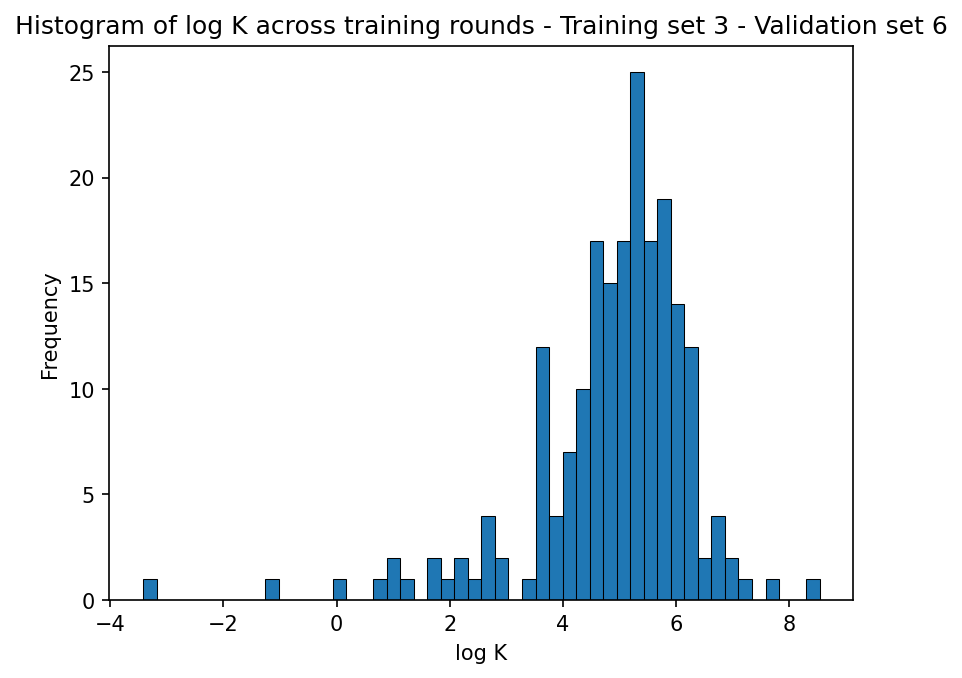

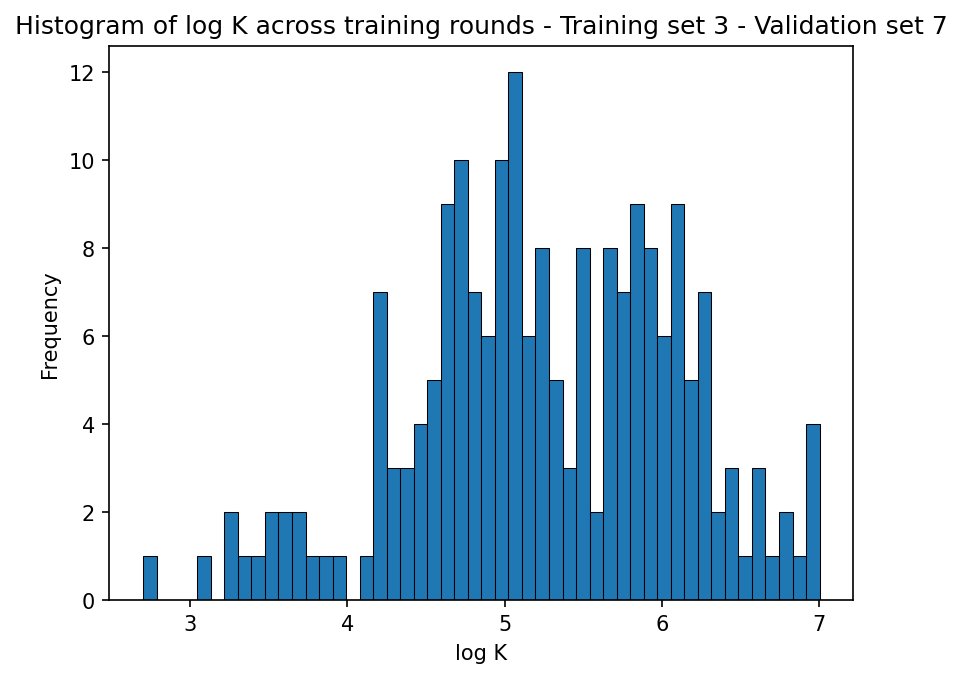

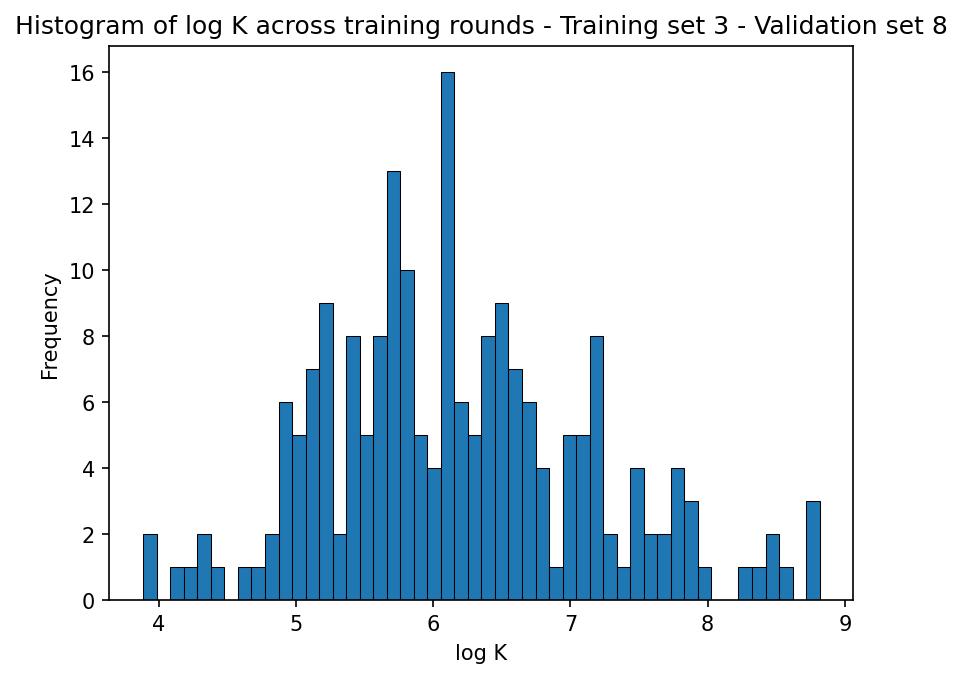

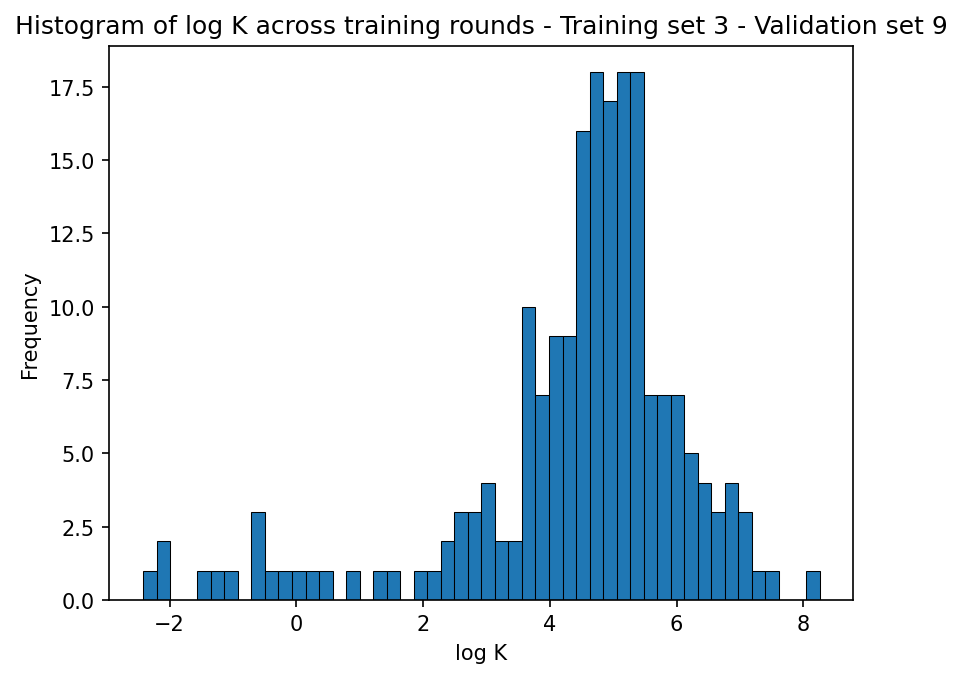

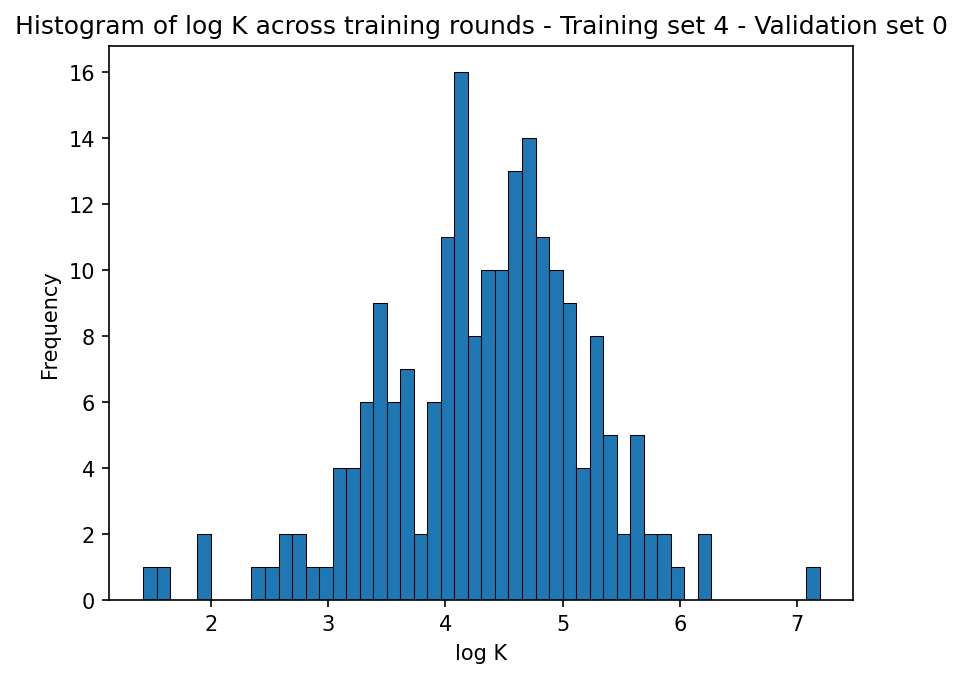

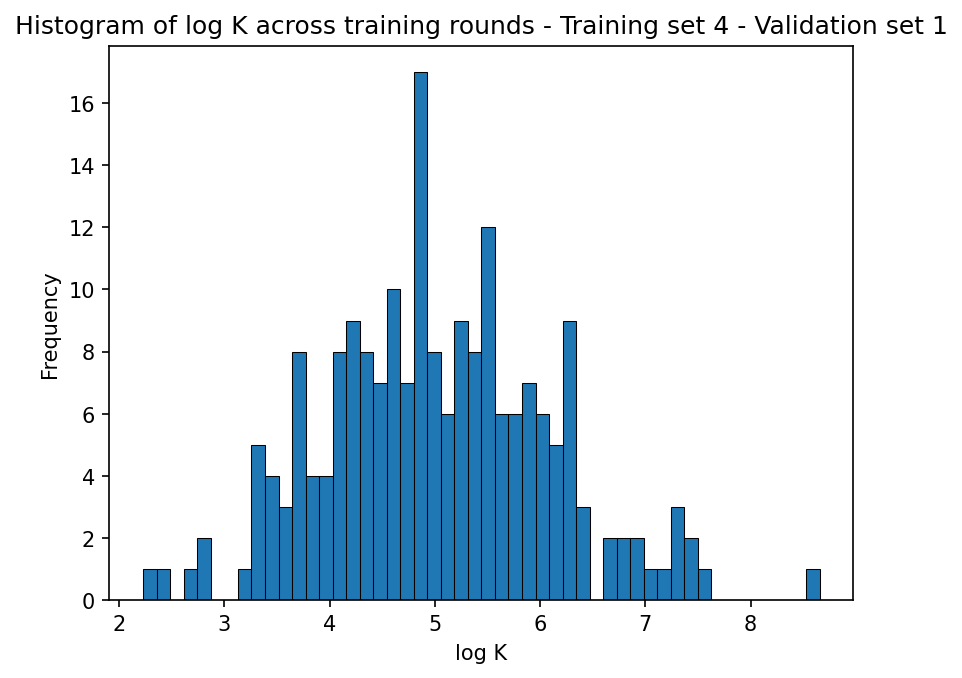

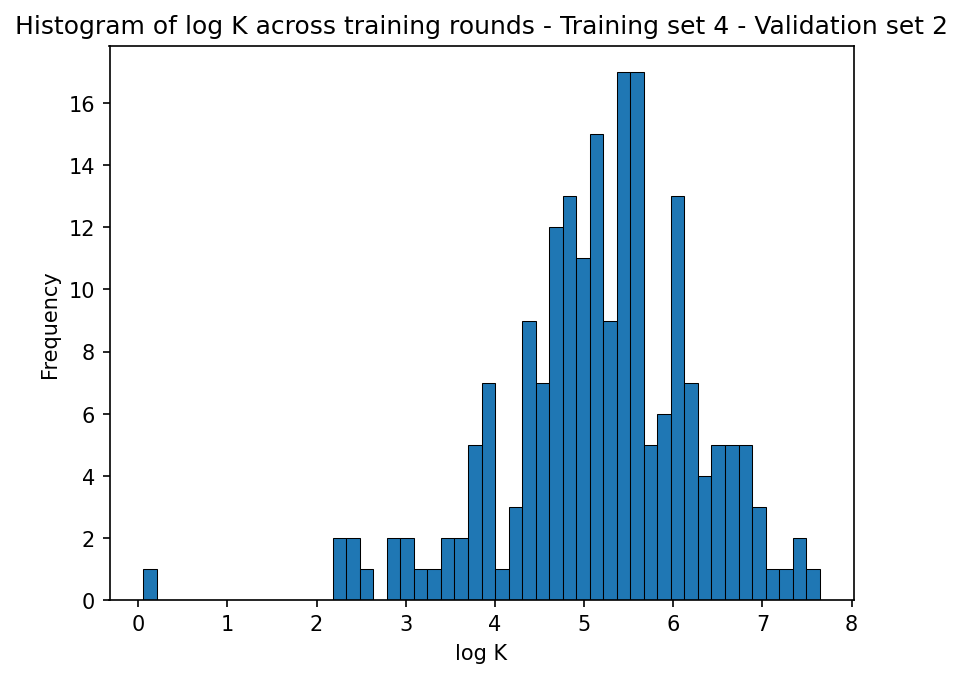

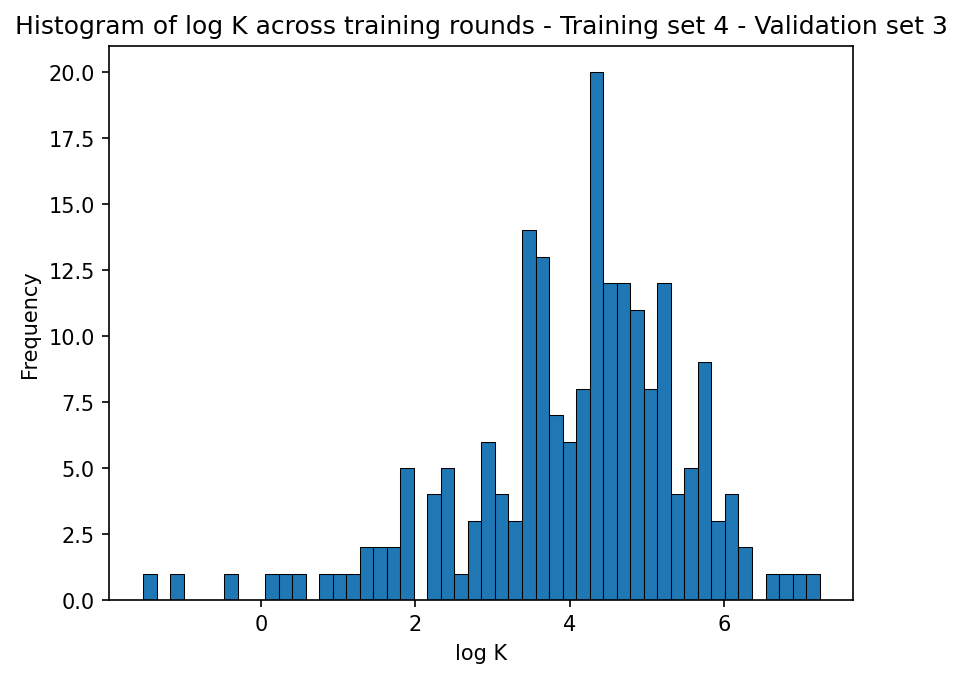

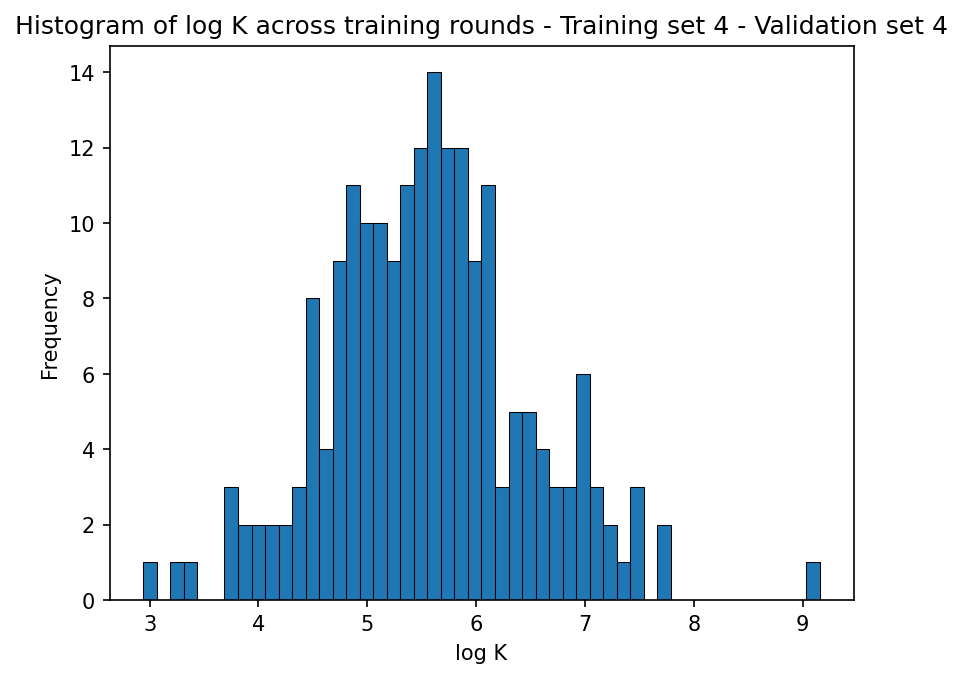

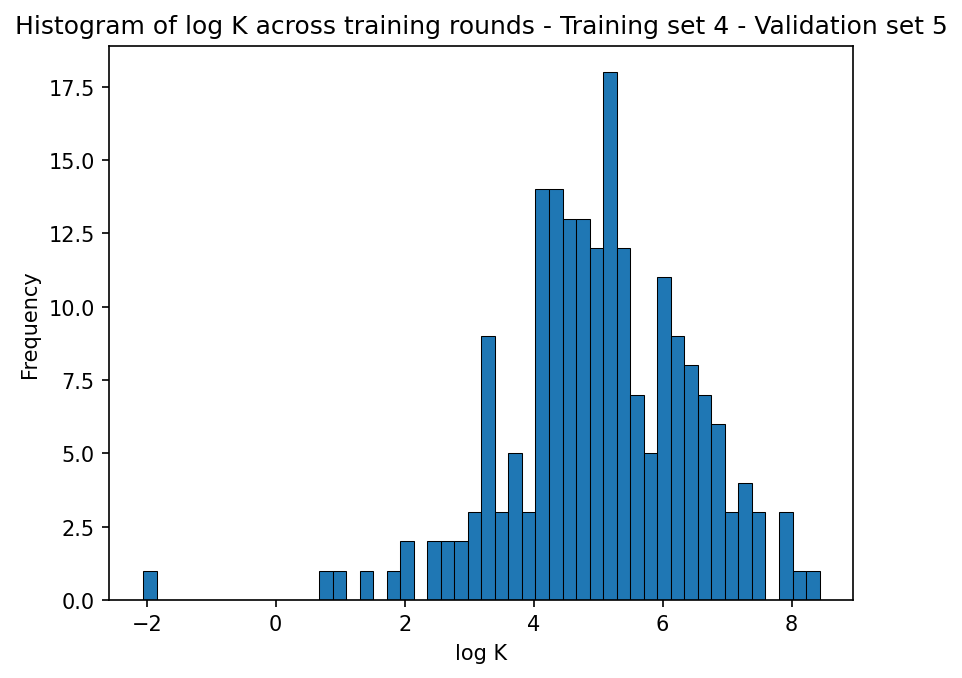

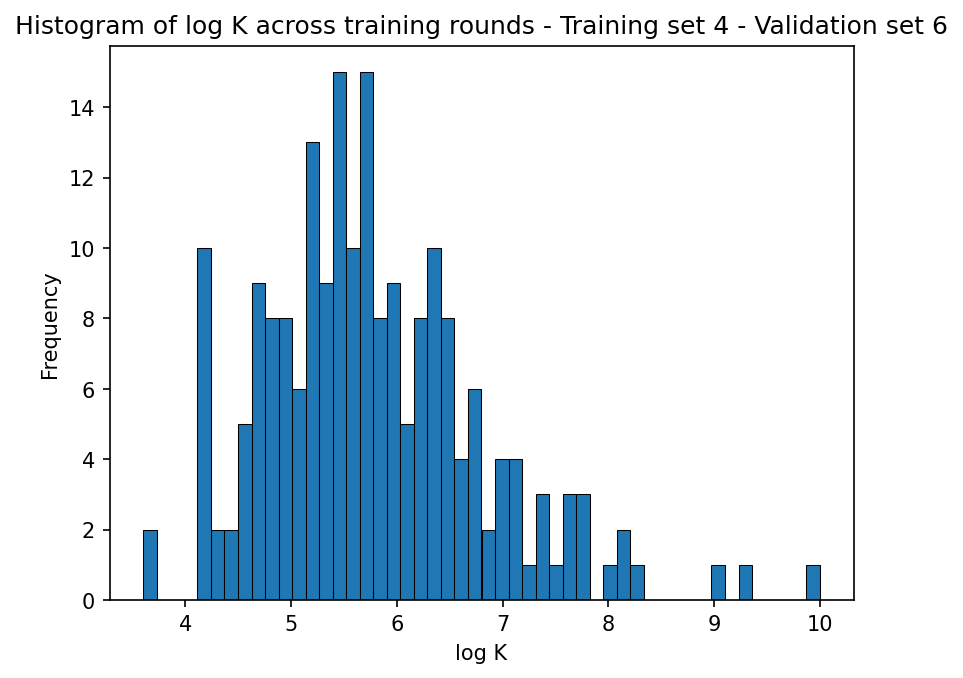

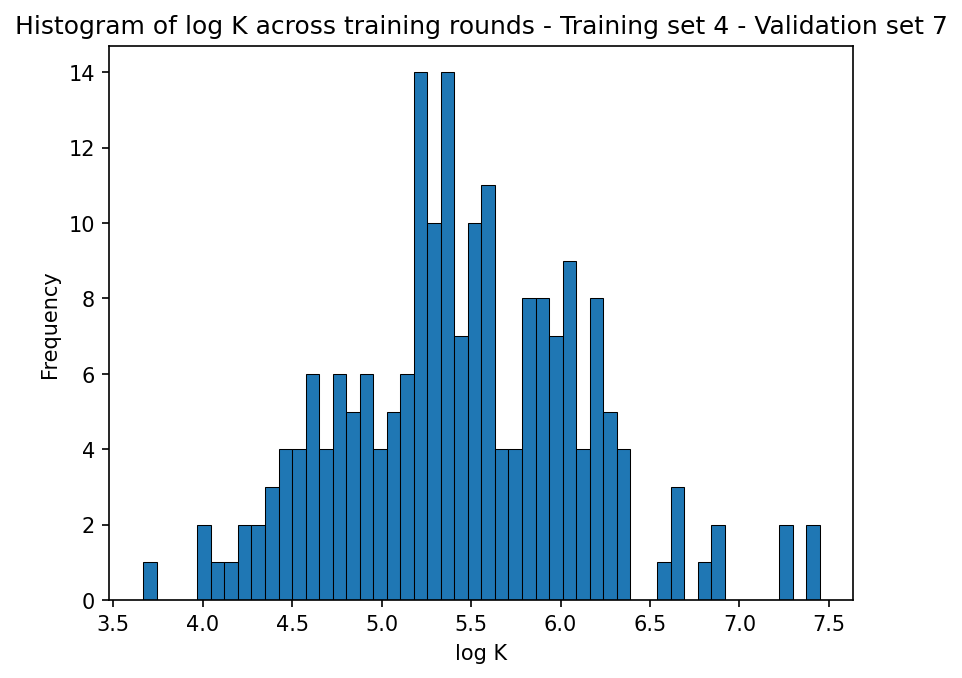

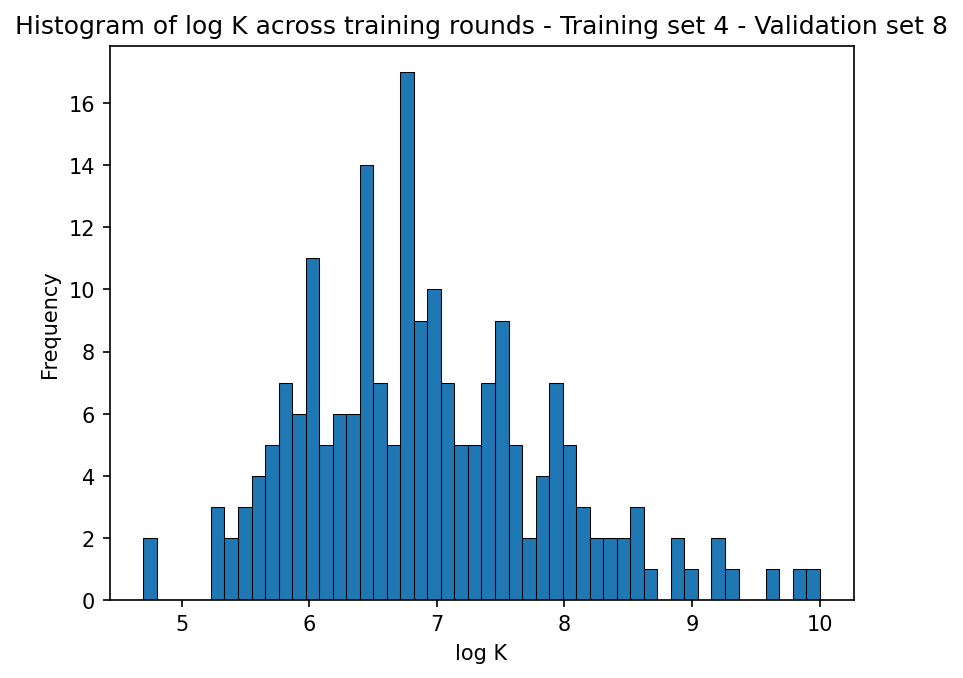

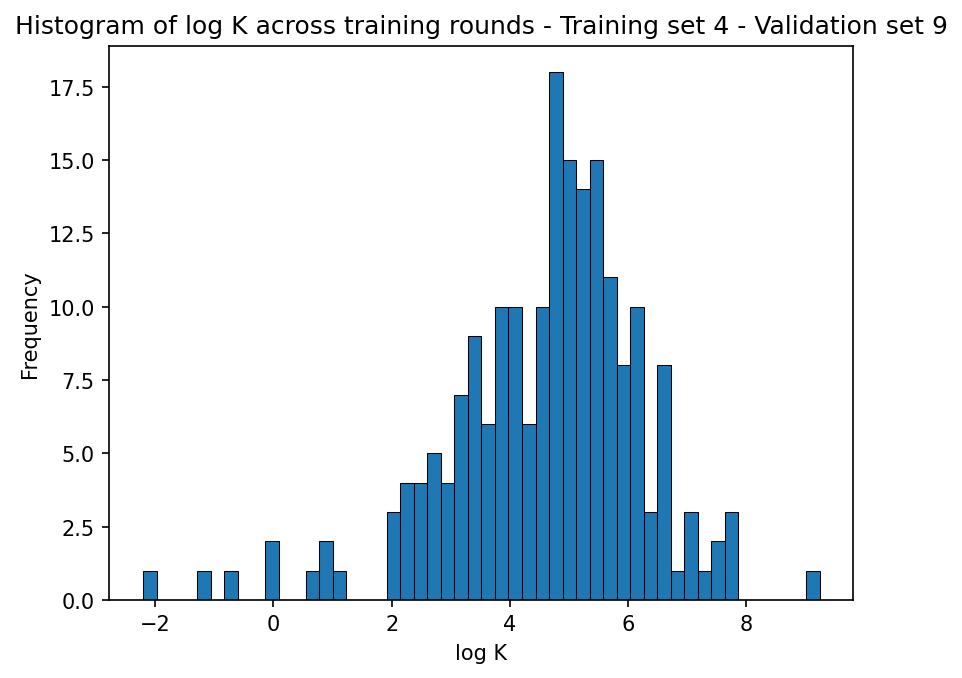

In [66]:
file = 'FINAL2_i2vsi3_BCT_i2_data_log_K_arrays_20240515_015544.npz'
log_K_array = np.load(file)['array0']

# Calculate averages across training rounds and training sets
num_train_rounds = log_K_array.shape[2]
num_val_datasets = log_K_array.shape[1]
num_sim_dataset_arrays_train_on = log_K_array.shape[0]
logk_trainsets_valsets_avg_over_trainrounds = np.sum(log_K_array, axis=2) / num_train_rounds
logk_avg_over_trainsets_valset_avg_over_trainrounds = np.sum(logk_trainsets_valsets_avg_over_trainrounds, axis=0) / num_sim_dataset_arrays_train_on

for i in range(num_sim_dataset_arrays_train_on):

    for j in range(num_val_datasets):
        plt.figure(dpi=150)
        plt.hist(log_K_array[i][j], bins=50, color = 'C0', edgecolor = 'black', linewidth = 0.5)
        plt.title(f'Histogram of log K across training rounds - Training set {i} - Validation set {j}')
        plt.xlabel('log K')
        plt.ylabel('Frequency')
        plt.show()

### Table and Histogram across val sets

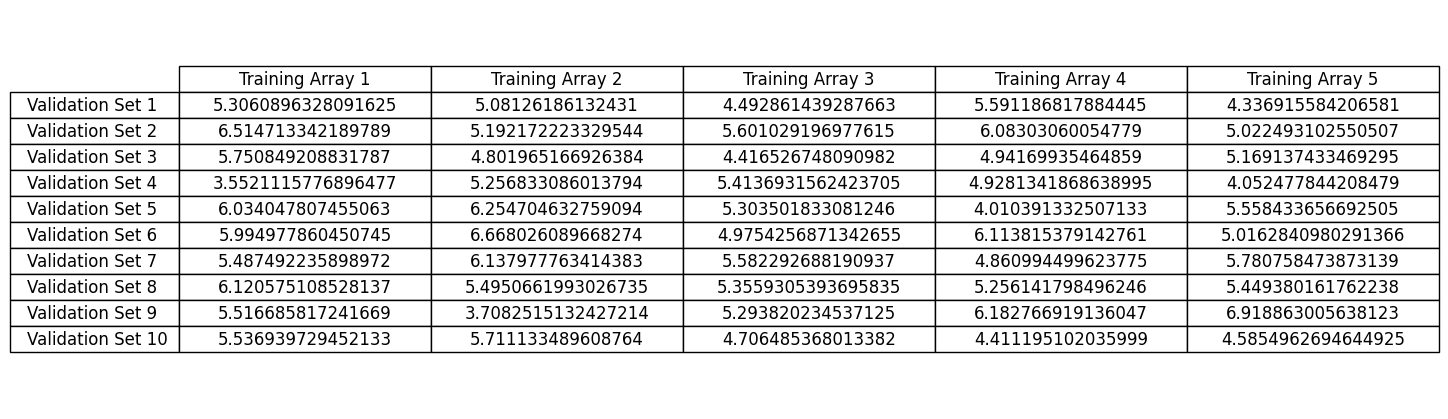

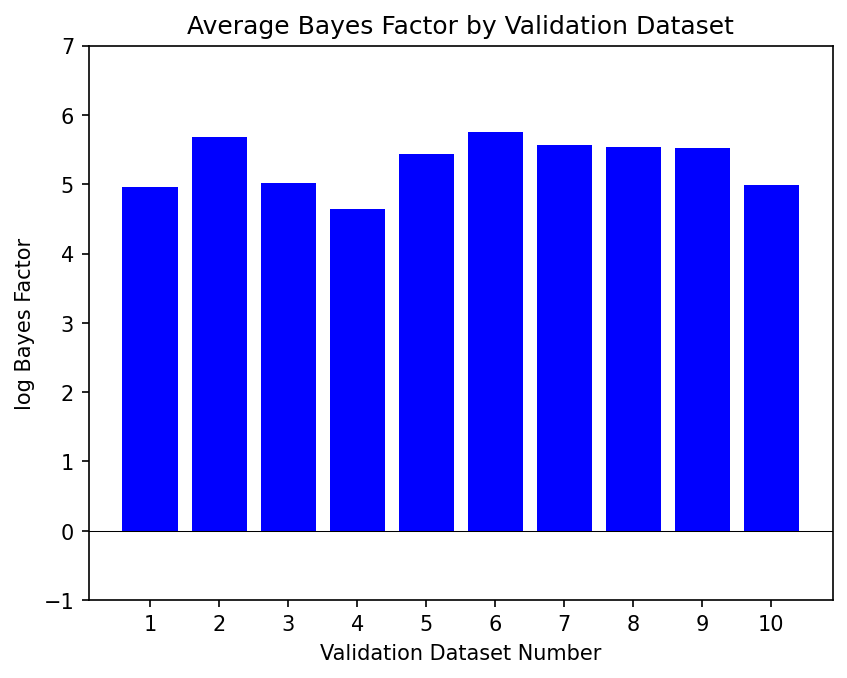

In [77]:
file = 'FINAL2_i2vsi3_BCT_i2_data_log_K_arrays_20240515_015544.npz'
log_K_array = np.load(file)['array0']

# Calculate averages across training rounds and training sets
num_train_rounds = log_K_array.shape[2]
num_val_datasets = log_K_array.shape[1]
num_sim_dataset_arrays_train_on = log_K_array.shape[0]
logk_trainsets_valsets_avg_over_trainrounds = np.sum(log_K_array, axis=2) / num_train_rounds
logk_avg_over_trainsets_valset_avg_over_trainrounds = np.sum(logk_trainsets_valsets_avg_over_trainrounds, axis=0) / num_sim_dataset_arrays_train_on

# Data provided
data = logk_trainsets_valsets_avg_over_trainrounds

# Creating a figure and axis object
fig, ax = plt.subplots(figsize=(14, 5))  # Adjust the figure size for better fitting

# Hide axes
ax.axis('off')
ax.axis('tight')

# Create table
column_labels = [f"Training Array {i+1}" for i in range(5)]
row_labels = [f"Validation Set {i+1}" for i in range(10)]
the_table = ax.table(cellText=data.T,  # Transpose data for correct orientation
                     colLabels=column_labels,
                     rowLabels=row_labels,
                     cellLoc='center',
                     loc='center')

# Adjust font size and scale
the_table.auto_set_font_size(False)
the_table.set_fontsize(12)  # Set a fixed font size
the_table.scale(1, 1.5)  # Adjust scaling factor for column width (increased) and row height

# Adjust layout to make room for the table
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1)

# Show the plot
plt.show()

## TABLE

# Determine the colors for each bar
colors = ['blue' if x >= 0 else 'red' for x in logk_avg_over_trainsets_valset_avg_over_trainrounds]

# Create a bar chart
plt.figure(dpi=150)
plt.bar(range(1, num_val_datasets + 1), logk_avg_over_trainsets_valset_avg_over_trainrounds, color = colors)
plt.ylim([-1, 7])  # Set y-axis limits from -5 to 5 as specified
plt.xlabel('Validation Dataset Number')
plt.ylabel('log Bayes Factor')
plt.title('Average Bayes Factor by Validation Dataset')
plt.xticks(range(1, num_val_datasets + 1))  # Set x-ticks to match the number of validation datasets
plt.axhline(0, color='black', linewidth=0.5)  # Add a line at zero for reference
plt.show()

## i3 vs i4

### i3 validation data

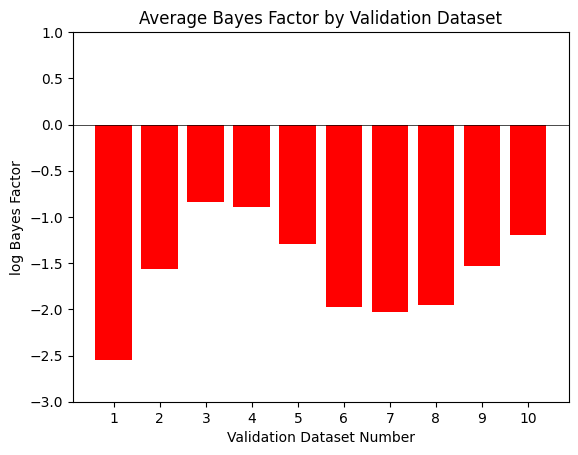

-1.5800851106017828


In [81]:
file = 'FINAL2_i3vsi4_BCT_i3_data_log_K_arrays_20240515_022051.npz'
log_K_array = np.load(file)['array0']

# Calculate averages across training rounds and training sets
num_train_rounds = log_K_array.shape[2]
num_val_datasets = log_K_array.shape[1]
num_sim_dataset_arrays_train_on = log_K_array.shape[0]
logk_trainsets_valsets_avg_over_trainrounds = np.sum(log_K_array, axis=2) / num_train_rounds
logk_avg_over_trainsets_valset_avg_over_trainrounds = np.sum(logk_trainsets_valsets_avg_over_trainrounds, axis=0) / num_sim_dataset_arrays_train_on
avg_log_k = np.sum(logk_avg_over_trainsets_valset_avg_over_trainrounds) / num_val_datasets

# Determine the colors for each bar
colors = ['blue' if x >= 0 else 'red' for x in logk_avg_over_trainsets_valset_avg_over_trainrounds]

# Create a bar chart
plt.figure(150)
plt.bar(range(1, num_val_datasets + 1), logk_avg_over_trainsets_valset_avg_over_trainrounds, color = colors)
plt.ylim([-3, 1])  # Set y-axis limits from -5 to 5 as specified
plt.xlabel('Validation Dataset Number')
plt.ylabel('log Bayes Factor')
plt.title('Average Bayes Factor by Validation Dataset')
plt.xticks(range(1, num_val_datasets + 1))  # Set x-ticks to match the number of validation datasets
plt.axhline(0, color='black', linewidth=0.5)  # Add a line at zero for reference
plt.show()
print(avg_log_k)

### i4 validation data

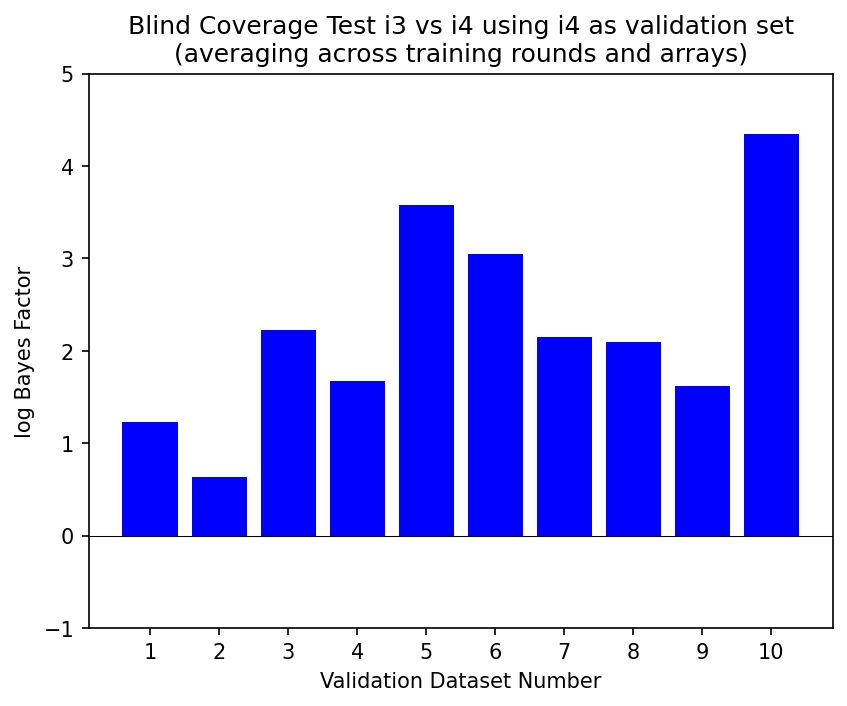

2.2611218845397234


In [85]:
file = 'FINAL2_i3vsi4_BCT_i4_data_log_K_arrays_20240515_034138.npz'
log_K_array = np.load(file)['array0']

# Calculate averages across training rounds and training sets
num_train_rounds = log_K_array.shape[2]
num_val_datasets = log_K_array.shape[1]
num_sim_dataset_arrays_train_on = log_K_array.shape[0]
logk_trainsets_valsets_avg_over_trainrounds = np.sum(log_K_array, axis=2) / num_train_rounds
logk_avg_over_trainsets_valset_avg_over_trainrounds = np.sum(logk_trainsets_valsets_avg_over_trainrounds, axis=0) / num_sim_dataset_arrays_train_on
avg_log_k = np.sum(logk_avg_over_trainsets_valset_avg_over_trainrounds) / num_val_datasets

# Determine the colors for each bar
colors = ['blue' if x >= 0 else 'red' for x in logk_avg_over_trainsets_valset_avg_over_trainrounds]

# Create a bar chart
plt.figure(dpi=150)
plt.bar(range(1, num_val_datasets + 1), logk_avg_over_trainsets_valset_avg_over_trainrounds, color = colors)
plt.ylim([-1, 5])  # Set y-axis limits from -5 to 5 as specified
plt.xlabel('Validation Dataset Number')
plt.ylabel('log Bayes Factor')
plt.title('Blind Coverage Test i3 vs i4 using i4 as validation set\n(averaging across training rounds and arrays)')
plt.xticks(range(1, num_val_datasets + 1))  # Set x-ticks to match the number of validation datasets
plt.axhline(0, color='black', linewidth=0.5)  # Add a line at zero for reference
plt.show()
print(avg_log_k)

### Real data i2 vs i3

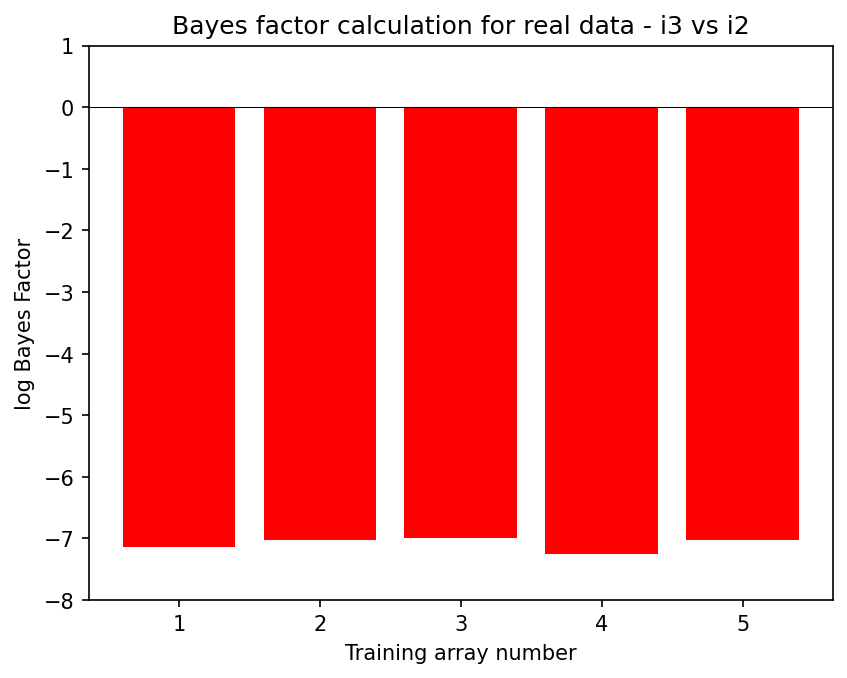

-7.0879301816225055


In [96]:
file = 'FINAL2_i2vsi3_real_data_log_K_arrays_20240515_040559.npz'
log_K_array = np.load(file)['array0']

# Calculate averages across training rounds and training sets
num_train_rounds = log_K_array.shape[2]
num_val_datasets = log_K_array.shape[1]
num_sim_dataset_arrays_train_on = log_K_array.shape[0]
logk_trainsets_valsets_avg_over_trainrounds = np.sum(log_K_array, axis=2) / num_train_rounds
logk_trainsets_avg_over_valset_avg_over_trainrounds = np.sum(logk_trainsets_valsets_avg_over_trainrounds, axis=1) / num_val_datasets
avg_log_k = np.sum(logk_trainsets_avg_over_valset_avg_over_trainrounds) / num_sim_dataset_arrays_train_on

# Determine the colors for each bar
colors = ['blue' if x >= 0 else 'red' for x in logk_trainsets_avg_over_valset_avg_over_trainrounds]

# Create a bar chart
plt.figure(dpi=150)
plt.bar(range(1, num_sim_dataset_arrays_train_on + 1), logk_trainsets_avg_over_valset_avg_over_trainrounds, color = colors)
plt.ylim([-8, 1])  # Set y-axis limits from -5 to 5 as specified
plt.xlabel('Training array number')
plt.ylabel('log Bayes Factor')
plt.title('Bayes factor calculation for real data - i3 vs i2')
plt.xticks(range(1, num_sim_dataset_arrays_train_on + 1))  # Set x-ticks to match the number of validation datasets
plt.axhline(0, color='black', linewidth=0.5)  # Add a line at zero for reference
plt.show()
print(avg_log_k)

### Real data i3 vs i4

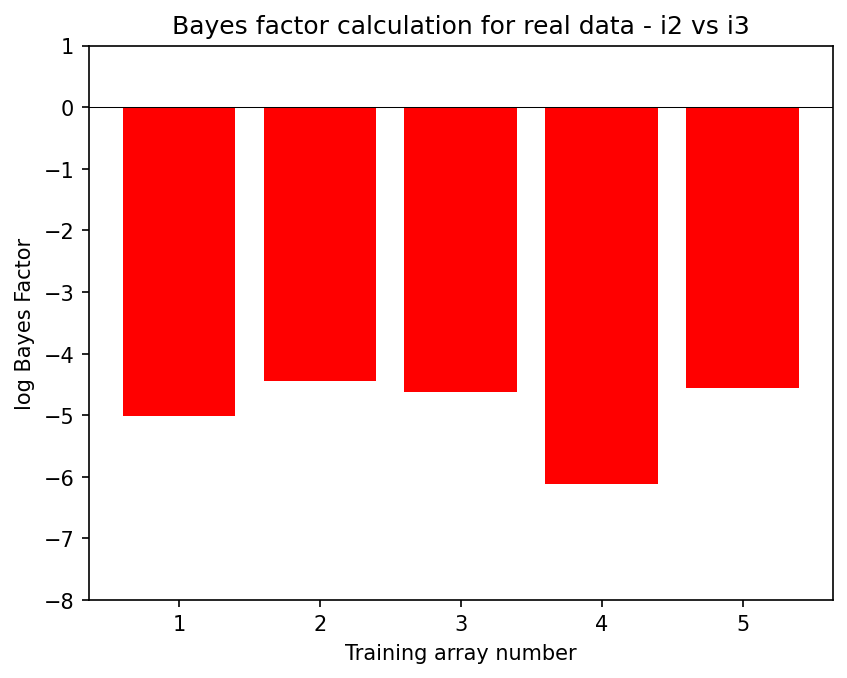

-4.951244185566902


In [95]:
file = 'FINAL2_i3vsi4_real_data_log_K_arrays_20240515_042816.npz'
log_K_array = np.load(file)['array0']

# Calculate averages across training rounds and training sets
num_train_rounds = log_K_array.shape[2]
num_val_datasets = log_K_array.shape[1]
num_sim_dataset_arrays_train_on = log_K_array.shape[0]
logk_trainsets_valsets_avg_over_trainrounds = np.sum(log_K_array, axis=2) / num_train_rounds
logk_trainsets_avg_over_valset_avg_over_trainrounds = np.sum(logk_trainsets_valsets_avg_over_trainrounds, axis=1) / num_val_datasets
avg_log_k = np.sum(logk_trainsets_avg_over_valset_avg_over_trainrounds) / num_sim_dataset_arrays_train_on

# Determine the colors for each bar
colors = ['blue' if x >= 0 else 'red' for x in logk_trainsets_avg_over_valset_avg_over_trainrounds]

# Create a bar chart
plt.figure(dpi=150)
plt.bar(range(1, num_sim_dataset_arrays_train_on + 1), logk_trainsets_avg_over_valset_avg_over_trainrounds, color = colors)
plt.ylim([-8, 1])  # Set y-axis limits from -5 to 5 as specified
plt.xlabel('Training array number')
plt.ylabel('log Bayes Factor')
plt.title('Bayes factor calculation for real data - i3 vs i4')
plt.xticks(range(1, num_sim_dataset_arrays_train_on + 1))  # Set x-ticks to match the number of validation datasets
plt.axhline(0, color='black', linewidth=0.5)  # Add a line at zero for reference
plt.show()
print(avg_log_k)

# Signal Detection

## Binary Model Comparison Signal Injection Test (prior sampling simulated signal generation)

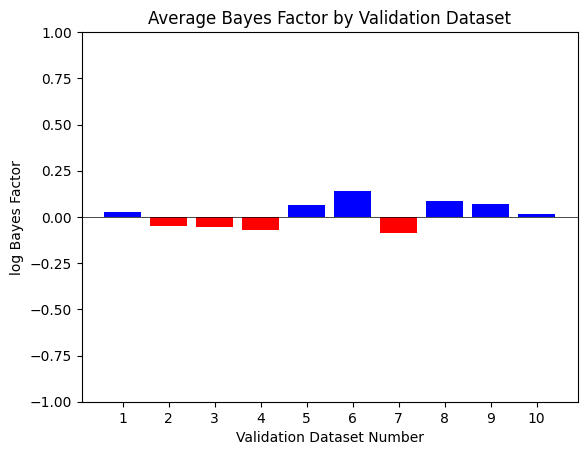

In [43]:
# Load the necessary data
file = 'validation_datasets_signal_in_bin_3_pre_filter4_20240510_140323.npz'
data = np.load(file)
array_vector_datasets_validation = data['array0']
signal_values_array = data['array1']
num_val_datasets = len(array_vector_datasets_validation)

file2 = 'FINAL_bckg_vs_bckg+signal_prior_gen_inj_test_bin3_log_K_arrays_20240511_232102.npz'
log_K_array = np.load(file2)['array0']

# Calculate averages across training rounds and training sets
num_train_rounds = log_K_array.shape[2]
num_sim_dataset_arrays_train_on = log_K_array.shape[0]
logk_trainsets_valsets_avg_over_trainrounds = np.sum(log_K_array, axis=2) / num_train_rounds
logk_avg_over_trainsets_valset_avg_over_trainrounds = np.sum(logk_trainsets_valsets_avg_over_trainrounds, axis=0) / num_sim_dataset_arrays_train_on

# Determine the colors for each bar
colors = ['blue' if x >= 0 else 'red' for x in logk_avg_over_trainsets_valset_avg_over_trainrounds]

# Create a bar chart
plt.bar(range(1, num_val_datasets + 1), logk_avg_over_trainsets_valset_avg_over_trainrounds, color = colors)
plt.ylim([-1, 1])  # Set y-axis limits from -5 to 5 as specified
plt.xlabel('Validation Dataset Number')
plt.ylabel('log Bayes Factor')
plt.title('Average Bayes Factor by Validation Dataset')
plt.xticks(range(1, num_val_datasets + 1))  # Set x-ticks to match the number of validation datasets
plt.axhline(0, color='black', linewidth=0.5)  # Add a line at zero for reference
plt.show()

## Binary model comparison Signal Injection Test (binned simulated signal generation)

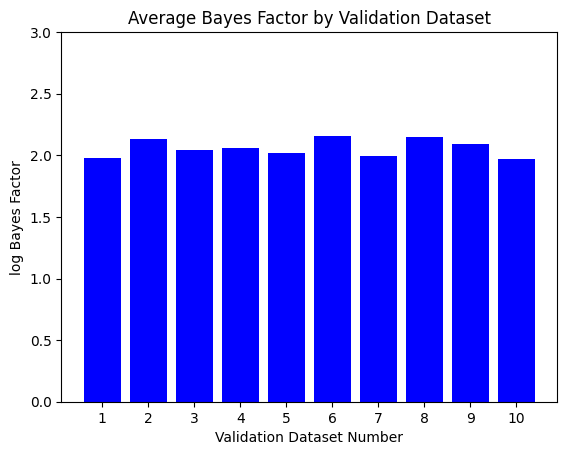

In [45]:
# Load the necessary data
file = 'validation_datasets_signal_in_bin_3_pre_filter4_20240510_140323.npz'
data = np.load(file)
array_vector_datasets_validation = data['array0']
signal_values_array = data['array1']
num_val_datasets = len(array_vector_datasets_validation)

file2 = 'FINAL_bckg_vs_bckg+signal_bin_wise_gen_inj_test_bin3_log_K_arrays_20240511_200418.npz'
log_K_array = np.load(file2)['array0']

# Calculate averages across training rounds and training sets
num_train_rounds = log_K_array.shape[2]
num_sim_dataset_arrays_train_on = log_K_array.shape[0]
logk_trainsets_valsets_avg_over_trainrounds = np.sum(log_K_array, axis=2) / num_train_rounds
logk_avg_over_trainsets_valset_avg_over_trainrounds = np.sum(logk_trainsets_valsets_avg_over_trainrounds, axis=0) / num_sim_dataset_arrays_train_on

# Create a bar chart
plt.bar(range(1, num_val_datasets + 1), logk_avg_over_trainsets_valset_avg_over_trainrounds, color = 'blue')
plt.ylim([0, 3])  # Set y-axis limits from -5 to 5 as specified
plt.xlabel('Validation Dataset Number')
plt.ylabel('log Bayes Factor')
plt.title('Average Bayes Factor by Validation Dataset')
plt.xticks(range(1, num_val_datasets + 1))  # Set x-ticks to match the number of validation datasets
plt.axhline(0, color='black', linewidth=0.5)  # Add a line at zero for reference
plt.show()

## Binary model comparison False Positive Test (binned simulated signal generation)